In [2]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import isingmodellight
from isingmodellight import IsingModelLight
from scipy import stats
import time
import hcpdatautils as hcp
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [4]:
file_dir = 'E:\\Ising_model_results_daai'
other_file_dir = 'D:\\Ising_model_results_daai'

In [5]:
training_subject_start=0
training_subject_end = 670

In [6]:
def depytorch(t:torch.Tensor):
    return t.detach().cpu().numpy()

In [7]:
def make_histogram(name:str, values:torch.Tensor):
    fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
    axs.hist(  depytorch( values.flatten() )  )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(name)
    axs.set_ylabel('count in bin')
    axs.set_title(f'distribution of {name}')
    plt.show()

In [8]:
def print_stats(name:str, values:torch.Tensor):
    values = values.flatten()
    quantile_cutoffs = torch.tensor([0.025, 0.5, 0.975], dtype=float_type, device=device)
    quantiles = torch.quantile(values, quantile_cutoffs)
    min_val = torch.min(values)
    max_val = torch.max(values)
    print(f'The distribution of {name} values has median {quantiles[1].item():.3g} with 95% CI [{quantiles[0].item():.3g}, {quantiles[2].item():.3g}] and range [{min_val.item():.3g}, {max_val.item():.3g}].')

In [9]:
def get_closest_match(values:torch.Tensor, target:float):
    return torch.argmin( torch.abs(values - target) )

In [10]:
def make_scatter_plot_with_regression_line(ax, feature:torch.Tensor, param:torch.Tensor, feature_name:str, param_name:str):
    # We assume both Tensors are 1D and the same size.
    
    feature_and_1 = torch.stack(  ( feature, torch.ones_like(feature) ), dim=-1  )
    param_col = param.unsqueeze(dim=-1)
    lst_sq_result = torch.linalg.lstsq(feature_and_1, param_col)
    param_pred = torch.matmul(feature_and_1, lst_sq_result.solution).flatten()
    param_mean = torch.mean(param)
    r_squared = 1 - torch.sum( torch.square(param - param_pred) )/torch.sum( torch.square(param - param_mean) )
    corr = isingmodellight.get_pairwise_correlation(mat1=param, mat2=feature, dim=0)
    
    slope = lst_sq_result.solution[0].item()
    intercept = lst_sq_result.solution[1].item()
    print(f'{param_name}={slope:.3g}{feature_name}+{intercept:.3g}, R^2={r_squared:.3g}, corr.={corr:.3g}')
    
    feature_np = depytorch(feature)
    param_np = depytorch(param)
    param_pred_np = depytorch(param_pred)
    ax.scatter(feature_np, param_np, color='blue')
    ax.plot(feature_np, param_pred_np, color='orange', linewidth=3)
    # ax.text( x=0.0, y=param_mean.item(), s=f'R^2={r_squared:.3g}, corr.={corr:.3g}' )
    ax.set_xlabel(f'{feature_name}')
    ax.set_ylabel(f'{param_name}')

In [11]:
plt.rcParams.update({'font.size': 20})
line_width = 3

In [11]:
data_ts = torch.load( os.path.join(file_dir, 'data_ts_all_as_is_aal.pt'), weights_only=False )
print( data_ts.size() )

torch.Size([4, 837, 117, 1200])


In [12]:
data_ts_std, data_ts_mean = torch.std_mean(data_ts, dim=-1, keepdim=True)
data_ts_z = (data_ts - data_ts_mean)/data_ts_std

In [22]:
example_ts_index = 0
example_subject_index = 0
min_example_time = 30
max_example_time = 330

In [23]:
example_ts = data_ts_z[example_ts_index,example_subject_index,:,min_example_time:max_example_time]
print( example_ts.size() )

torch.Size([117, 300])


In [24]:
step_size = 0.72
times = step_size * torch.arange( example_ts.size(dim=-1), dtype=example_ts.dtype, device=example_ts.device )
print( times.size() )

torch.Size([300])


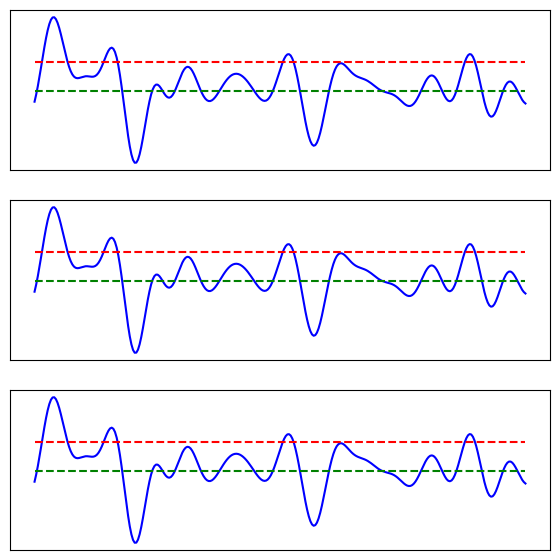

In [25]:
ts_curve = example_ts[roi_index,:]
mean_line = torch.zeros_like(ts_curve)
sd_line = torch.ones_like(ts_curve)
fig, axs = plt.subplots( nrows=3, ncols=1, figsize=(6, 6) )
for roi_index in range(3):
    axs[roi_index].plot( depytorch(times), depytorch(ts_curve), linestyle='-', color='blue' )
    axs[roi_index].plot( depytorch(times), depytorch(mean_line), linestyle='--', color='green' )
    axs[roi_index].plot( depytorch(times), depytorch(sd_line), linestyle='--', color='red' )
    axs[roi_index].set_xticks([])
    axs[roi_index].set_yticks([])
fig.tight_layout()

In [25]:
binarized_ts = 2.0*(data_ts_z >= 1).float() - 1.0

In [36]:
example_binarized_ts = binarized_ts[example_ts_index,example_subject_index,:,:max_example_time]
print( example_binarized_ts.size() )

torch.Size([117, 300])


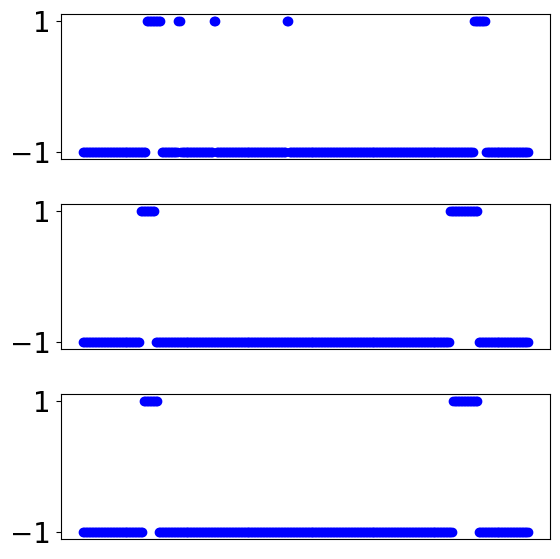

In [37]:
fig, axs = plt.subplots( nrows=3, ncols=1, figsize=(6, 6) )
for roi_index in range(3):
    axs[roi_index].scatter( depytorch(times), depytorch(example_binarized_ts[roi_index,:]), color='blue' )
    axs[roi_index].set_xticks([])
    axs[roi_index].set_yticks([-1, 1])
fig.tight_layout()

In [38]:
example_whole_ts = binarized_ts[example_ts_index,example_subject_index,:,:]
example_means = example_whole_ts.mean(dim=-1)
print( example_means.size() )
example_mean_products = torch.matmul( example_whole_ts, example_whole_ts.transpose(dim0=0, dim1=1) )/example_whole_ts.size(dim=-1)
print( example_mean_products.size() )

torch.Size([117])
torch.Size([117, 117])


In [77]:
num_thresholds = 31
min_threshold = 0.0
max_threshold = 3.0
threshold = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=float_type, device=device)
data_string = f'thresholds_{num_thresholds}_min_{min_threshold:.3g}_max_{max_threshold:.3g}'
mean_state = torch.load( os.path.join(other_file_dir, f'mean_state_{data_string}.pt'), weights_only=False )
print( mean_state.size() )
mean_state_product = torch.load( os.path.join(other_file_dir, f'mean_state_product_{data_string}.pt'), weights_only=False )
print( mean_state_product.size() )

torch.Size([31, 360])
torch.Size([31, 360, 360])


In [12]:
threshold_index = get_closest_match(values=threshold, target=1.0)
selected_mean_state = mean_state[threshold_index,:]
selected_mean_state_product = mean_state_product[threshold_index,:,:]

[]

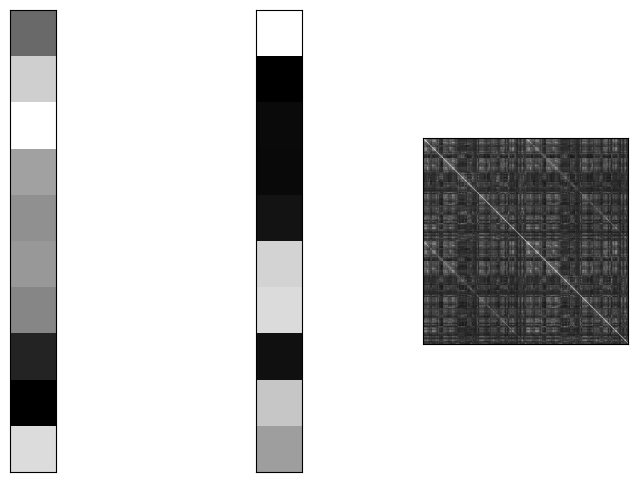

In [13]:
cmap = 'gray'
fig, axs = plt.subplots( nrows=1, ncols=3, figsize=(9, 6) )
axs[0].imshow(  depytorch( selected_mean_state[:10].unsqueeze(dim=-1) ), cmap=cmap  )
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].imshow(  depytorch( selected_mean_state[-10:].unsqueeze(dim=-1) ), cmap=cmap  )
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].imshow( depytorch(selected_mean_state_product), cmap=cmap )
axs[2].set_xticks([])
axs[2].set_yticks([])

In [14]:
selected_std = torch.sqrt( 1 - selected_mean_state.square() )
selected_cov = selected_mean_state_product - selected_mean_state.unsqueeze(dim=1) * selected_mean_state.unsqueeze(dim=0)
selected_fc = selected_cov/( selected_std.unsqueeze(dim=1) * selected_std.unsqueeze(dim=0) )
print( selected_fc.size() )

torch.Size([360, 360])


[]

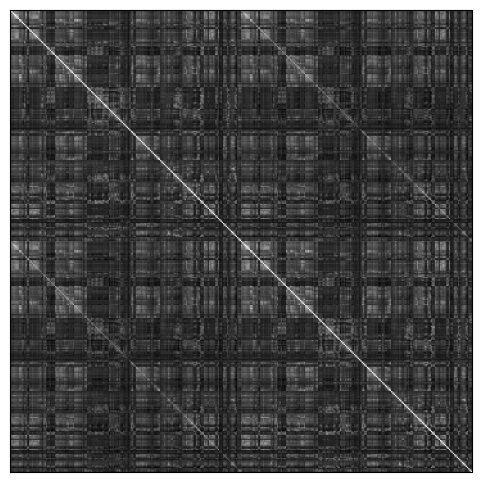

In [15]:
cmap = 'gray'
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.imshow( depytorch(selected_fc), cmap=cmap )
axs.set_xticks([])
axs.set_yticks([])

In [63]:
noise = 0.01*torch.randn_like(selected_fc)
symmetric_noise = noise + noise.transpose(dim0=0, dim1=1)
symmetric_noise_no_diag = symmetric_noise - torch.diag_embed( torch.diagonal(symmetric_noise) )
alternate_fc = selected_fc + symmetric_noise_no_diag

[]

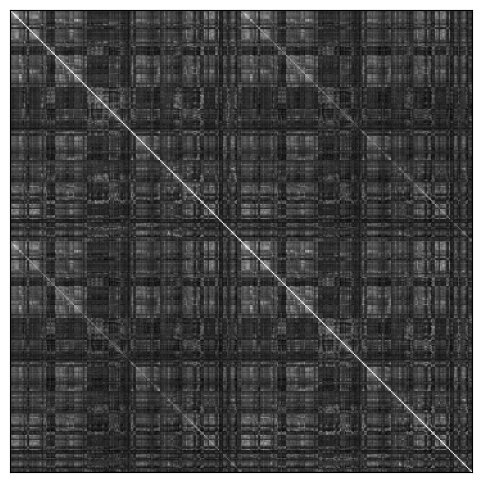

In [64]:
cmap = 'gray'
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.imshow( depytorch(alternate_fc), cmap=cmap )
axs.set_xticks([])
axs.set_yticks([])

In [40]:
node_features = torch.load( os.path.join(other_file_dir, 'node_features_all_as_is.pt'), weights_only=False )
print( node_features.size() )

torch.Size([837, 360, 11])


In [30]:
edge_features = torch.load( os.path.join(other_file_dir, 'edge_features_all_as_is.pt'), weights_only=False )
print( edge_features.size() )

torch.Size([837, 64620, 13])


In [31]:
mean_sc_triu = edge_features[:,:,0].mean(dim=0)
num_nodes = isingmodellight.num_pairs_to_num_nodes( num_pairs=mean_sc_triu.numel() )
mean_sc_square = torch.zeros( (num_nodes, num_nodes), dtype=mean_sc_triu.dtype, device=mean_sc_triu.device )
triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=num_nodes, device=mean_sc_triu.device )
mean_sc_square[triu_rows, triu_cols] = mean_sc_triu
mean_sc_square[triu_cols, triu_rows] = mean_sc_triu

[]

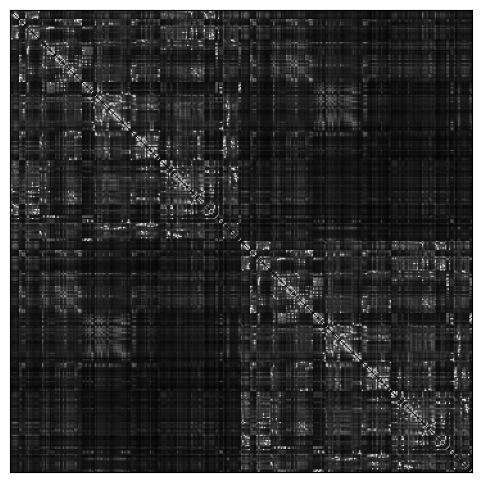

In [32]:
cmap = 'gray'
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.imshow(  depytorch( mean_sc_square.pow(1/4) ), cmap=cmap  )
axs.set_xticks([])
axs.set_yticks([])

In [78]:
model = torch.load( os.path.join(file_dir, f'ising_model_light_group_{data_string}_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt'), weights_only=False )
print( model.h.size() )
print( model.J.size() )

torch.Size([101, 31, 360])
torch.Size([101, 31, 360, 360])


In [86]:
threshold_index_x = get_closest_match(values=threshold, target=0.0)
threshold_index_y = get_closest_match(values=threshold, target=1.0)
threshold_x = threshold[threshold_index_x]
threshold_y = threshold[threshold_index_y]
h_x = model.h[:,threshold_index_x,:].mean(dim=0)
h_y = model.h[:,threshold_index_y,:].mean(dim=0)
J_x = model.J[:,threshold_index_x,:,:].mean(dim=0)
J_y = model.J[:,threshold_index_y,:,:].mean(dim=0)
h_h_correlation = isingmodellight.get_pairwise_correlation(mat1=h_x, mat2=h_y, epsilon=0.0, dim=0)
print(f'The correlation between group h at threshold={threshold_x:.3g} and group h at threshold={threshold_y:.3g} is {h_h_correlation:.3g}.')
J_J_correlation = isingmodellight.get_pairwise_correlation_ut( mat1=J_x.unsqueeze(dim=0).unsqueeze(dim=0), mat2=J_y.unsqueeze(dim=0).unsqueeze(dim=0), epsilon=0.0 ).squeeze()
print(f'The correlation between group J at threshold={threshold_x:.3g} and group J at threshold={threshold_y:.3g} is {J_J_correlation:.3g}.')

The correlation between group h at threshold=0 and group h at threshold=1 is -0.0118.
The correlation between group J at threshold=0 and group J at threshold=1 is 0.927.


Text(0, 0.5, 'J (threshold=1)')

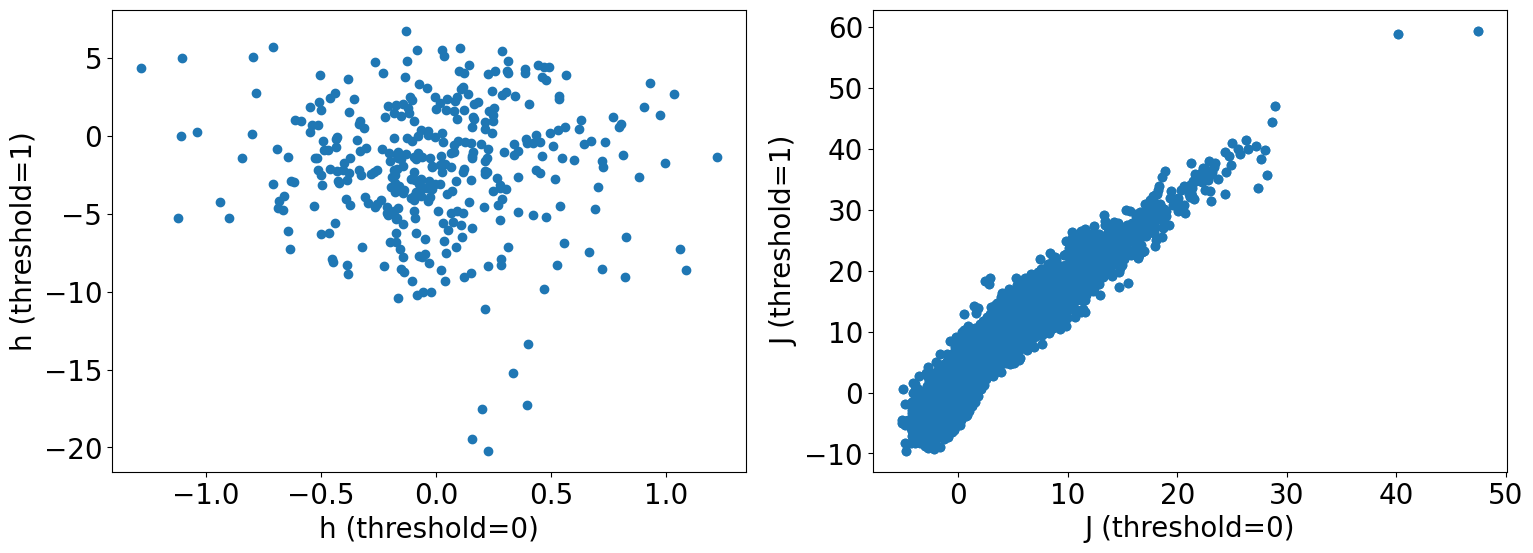

In [87]:
fig, axs = plt.subplots( nrows=1, ncols=2, figsize=(18, 6) )
axs[0].scatter( depytorch(h_x), depytorch(h_y) )
axs[0].set_xlabel(f'h (threshold={threshold_x:.3g})')
axs[0].set_ylabel(f'h (threshold={threshold_y:.3g})')
axs[1].scatter( depytorch(J_x), depytorch(J_y) )
axs[1].set_xlabel(f'J (threshold={threshold_x:.3g})')
axs[1].set_ylabel(f'J (threshold={threshold_y:.3g})')

In [88]:
J_J_diff = torch.abs(J_x - J_y)
min_J_J_diff = J_J_diff.min()
mean_J_J_diff = J_J_diff.mean()
max_J_J_diff = J_J_diff.max()
print(f'J-J difference min {min_J_J_diff:.3g}, mean {mean_J_J_diff:.3g}, max {max_J_J_diff:.3g}')

J-J difference min 0, mean 1.42, max 18.6


In [108]:
mean_h = model.h.mean(dim=0)
num_nodes = mean_h.size(dim=-1)

Text(0, 0.5, 'h')

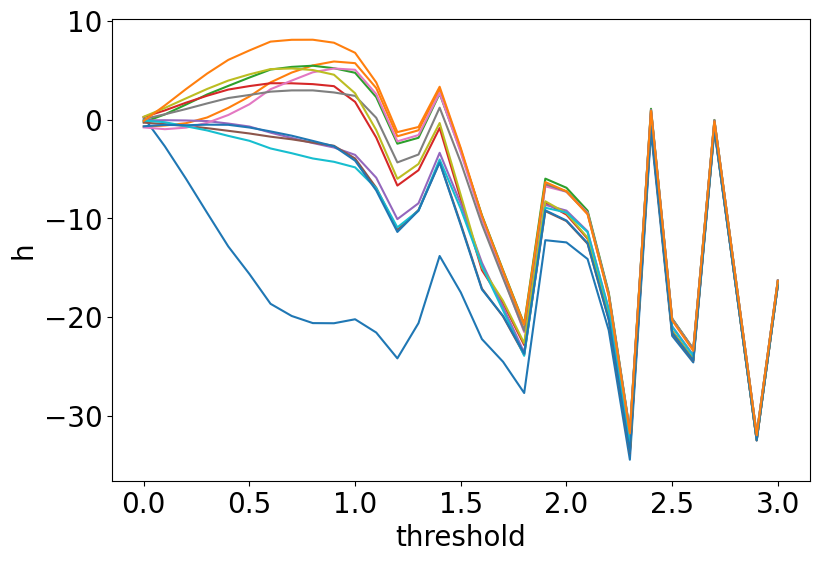

In [111]:
min_h_index = torch.argmin( torch.min(mean_h, dim=0).values )
max_h_index = torch.argmax( torch.max(mean_h, dim=0).values )
selected_h_indices = [min_h_index] + torch.arange(start=0, end=num_nodes, step=36, dtype=int_type, device=mean_h.device).tolist() + [max_h_index]
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
ax.plot( depytorch(threshold), depytorch(mean_h[:,selected_h_indices]) )
ax.set_xlabel('threshold')
ax.set_ylabel('h')

In [115]:
triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=model.J.size(dim=-1), device=model.J.device )
mean_J = model.J.mean(dim=0)[:,triu_rows,triu_cols]
num_edges = mean_J.size(dim=-1)
print( num_edges )

64620


Text(0, 0.5, 'J')

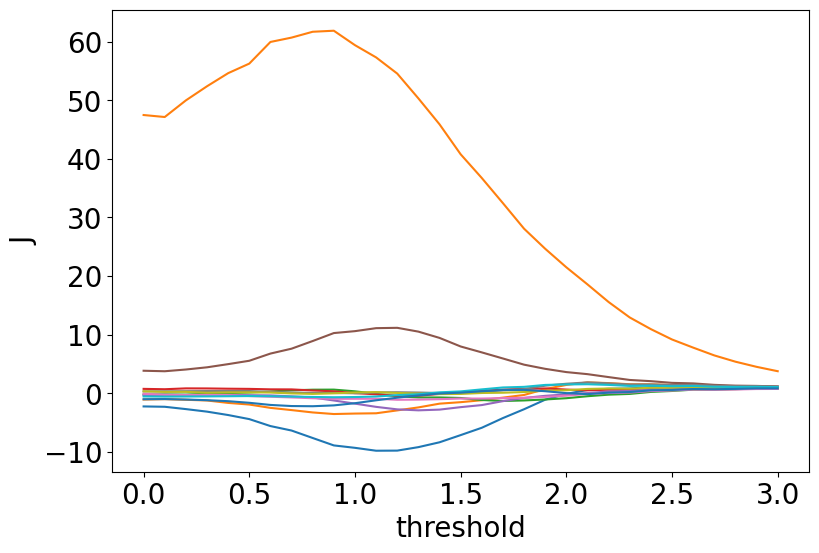

In [116]:
min_J_index = torch.argmin( torch.min(mean_J, dim=0).values )
max_J_index = torch.argmax( torch.max(mean_J, dim=0).values )
selected_J_indices = [min_J_index] + torch.arange(start=0, end=num_edges, step=6462, dtype=int_type, device=mean_J.device).tolist() + [max_J_index]
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
ax.plot( depytorch(threshold), depytorch(mean_J[:,selected_J_indices]) )
ax.set_xlabel('threshold')
ax.set_ylabel('J')

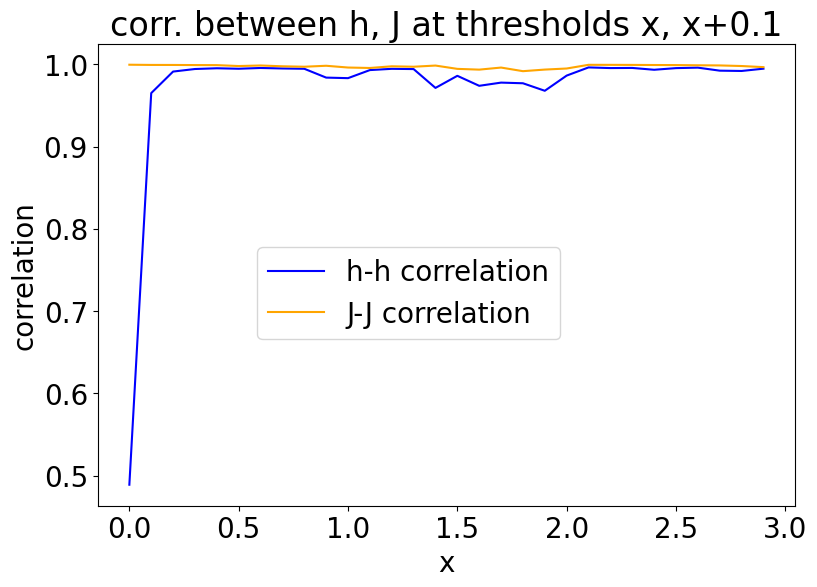

In [97]:
consecutive_h_correlation = isingmodellight.get_pairwise_correlation( mat1=mean_h[:-1,:], mat2=mean_h[1:,:], epsilon=0.0, dim=-1 )
consecutive_J_correlation = isingmodellight.get_pairwise_correlation( mat1=mean_J[:-1,:], mat2=mean_J[1:,:], epsilon=0.0, dim=-1 )
delta_thresh = threshold[1] - threshold[0]
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
ax.plot( depytorch(threshold[:-1]), depytorch(consecutive_h_correlation), label='h-h correlation', color='blue' )
ax.plot( depytorch(threshold[:-1]), depytorch(consecutive_J_correlation), label='J-J correlation', color='orange' )
ax.set_xlabel('x')
ax.set_ylabel('correlation')
ax.set_title(f'corr. between h, J at thresholds x, x+{delta_thresh:.3g}')
fig.legend(loc='center')

In [98]:
print( consecutive_J_correlation.min().item() )

0.9916706681251526


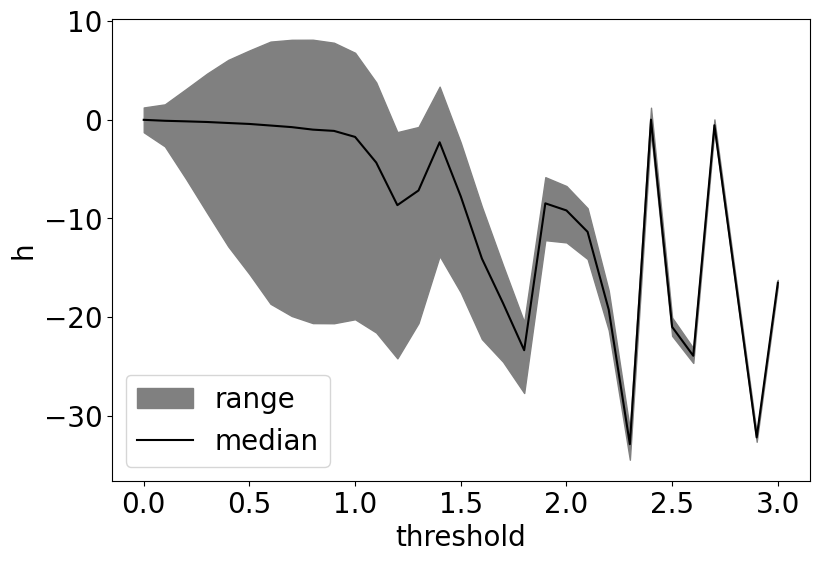

In [101]:
min_h = torch.min(mean_h, dim=-1).values
median_h = torch.median(mean_h, dim=-1).values
max_h = torch.max(mean_h, dim=-1).values
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
ax.fill_between( depytorch(threshold), depytorch(min_h), depytorch(max_h), color=[0.5, 0.5, 0.5], label='range' )
ax.plot( depytorch(threshold), depytorch(median_h), color=[0.0, 0.0, 0.0], label='median' )
ax.set_xlabel('threshold')
ax.set_ylabel('h')
ax.legend()

In [122]:
h_range = max_h - min_h
max_h_range_index = h_range.argmax()
max_h_range_threshold = threshold[max_h_range_index]
max_h_range = h_range[max_h_range_index]
print(f'The largest h range {max_h_range:.3g} occurs at threshold {max_h_range_threshold:.3g}.')

The largest h range 28.7 occurs at threshold 0.8.


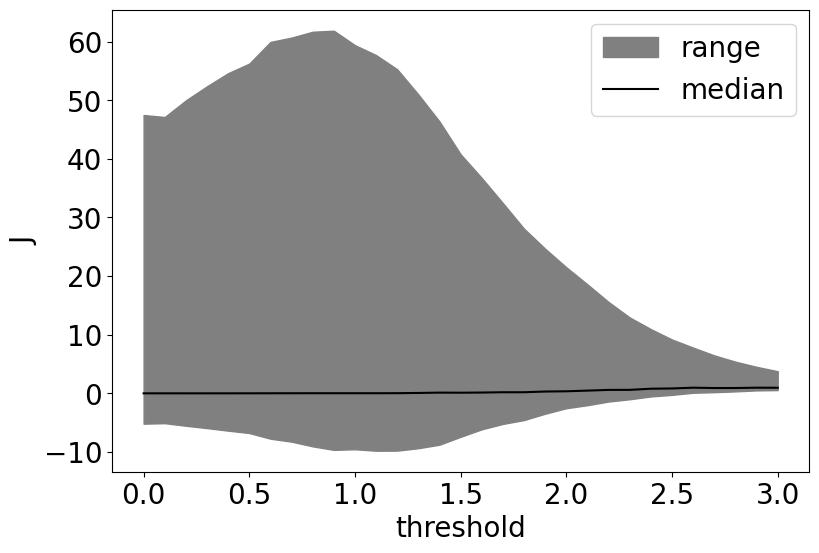

In [102]:
min_J = torch.min(mean_J, dim=-1).values
median_J = torch.median(mean_J, dim=-1).values
max_J = torch.max(mean_J, dim=-1).values
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
ax.fill_between( depytorch(threshold), depytorch(min_J), depytorch(max_J), color=[0.5, 0.5, 0.5], label='range' )
ax.plot( depytorch(threshold), depytorch(median_J), color=[0.0, 0.0, 0.0], label='median' )
ax.set_xlabel('threshold')
ax.set_ylabel('J')
ax.legend()

In [123]:
J_range = max_J - min_J
max_J_range_index = J_range.argmax()
max_J_range_threshold = threshold[max_J_range_index]
max_J_range = J_range[max_J_range_index]
print(f'The largest J range {max_J_range:.3g} occurs at threshold {max_J_range_threshold:.3g}.')

The largest J range 71.5 occurs at threshold 0.9.


torch.Size([31, 360])


Text(0.5, 0, 'threshold')

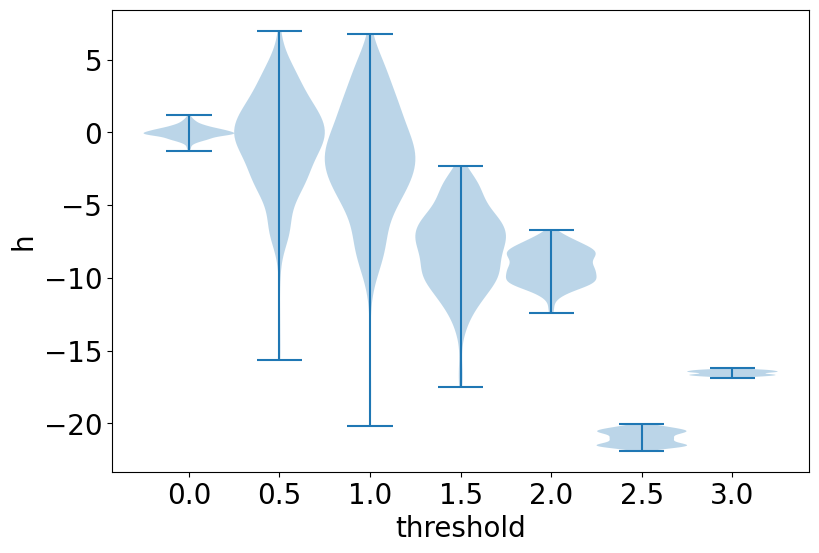

In [105]:
selected_threshold_indices = [0, 5, 10, 15, 20, 25, 30]
print( mean_h.size() )
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
ax.violinplot(  depytorch( mean_h.transpose(dim0=0, dim1=1)[:,selected_threshold_indices] ), positions=depytorch( threshold[selected_threshold_indices] )  )
ax.set_ylabel('h')
ax.set_xlabel('threshold')

torch.Size([31, 64620])


Text(0.5, 0, 'threshold')

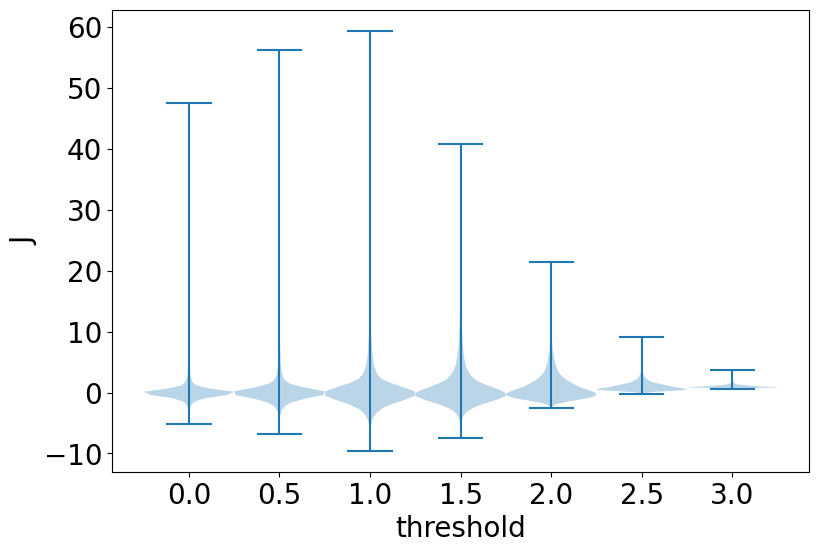

In [106]:
selected_threshold_indices = [0, 5, 10, 15, 20, 25, 30]
print( mean_J.size() )
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
ax.violinplot(  depytorch( mean_J.transpose(dim0=0, dim1=1)[:,selected_threshold_indices] ), positions=depytorch( threshold[selected_threshold_indices] )  )
ax.set_ylabel('J')
ax.set_xlabel('threshold')

In [118]:
print( model.beta.size() )
beta_h = model.beta.unsqueeze(dim=-1) * model.h
mean_beta_h = beta_h.mean(dim=0)
beta_J = model.beta.unsqueeze(dim=-1).unsqueeze(dim=-1) * model.J
mean_beta_J = beta_J.mean(dim=0)[:,triu_rows,triu_cols]

torch.Size([101, 31])


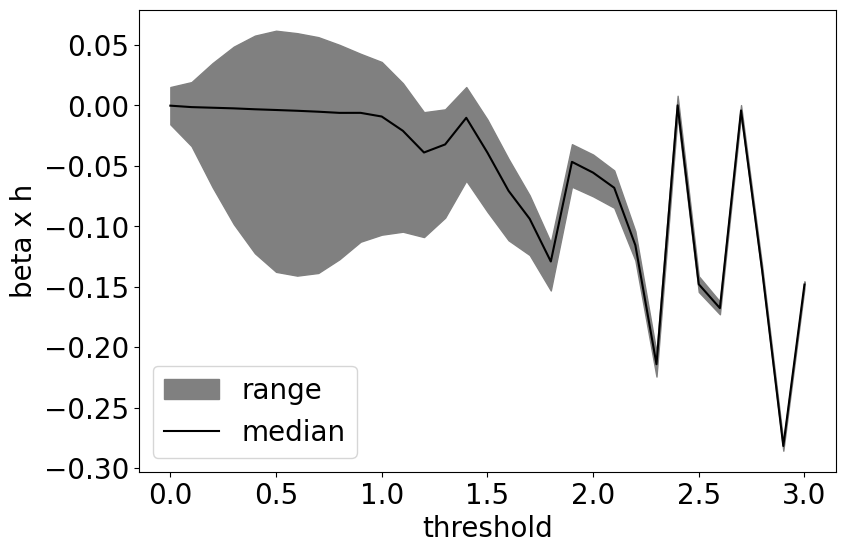

In [120]:
min_beta_h = torch.min(mean_beta_h, dim=-1).values
median_beta_h = torch.median(mean_beta_h, dim=-1).values
max_beta_h = torch.max(mean_beta_h, dim=-1).values
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
ax.fill_between( depytorch(threshold), depytorch(min_beta_h), depytorch(max_beta_h), color=[0.5, 0.5, 0.5], label='range' )
ax.plot( depytorch(threshold), depytorch(median_beta_h), color=[0.0, 0.0, 0.0], label='median' )
ax.set_xlabel('threshold')
ax.set_ylabel('beta x h')
ax.legend()

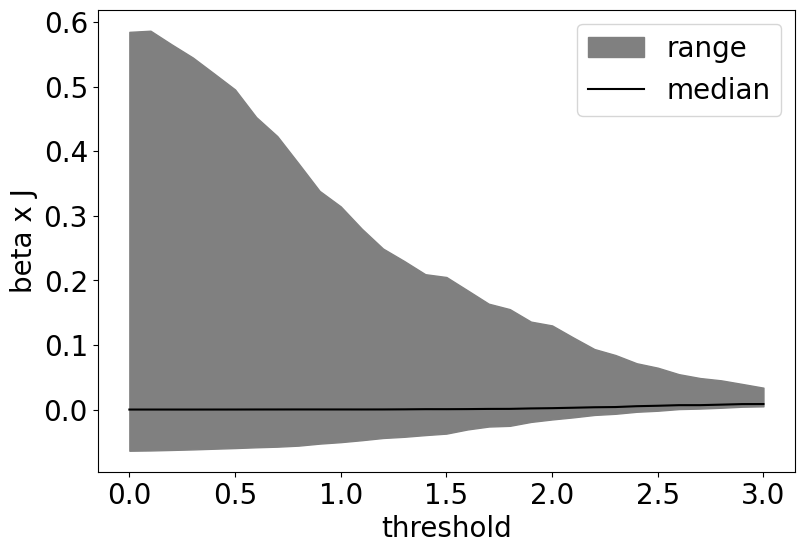

In [121]:
min_beta_J = torch.min(mean_beta_J, dim=-1).values
median_beta_J = torch.median(mean_beta_J, dim=-1).values
max_beta_J = torch.max(mean_beta_J, dim=-1).values
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
ax.fill_between( depytorch(threshold), depytorch(min_beta_J), depytorch(max_beta_J), color=[0.5, 0.5, 0.5], label='range' )
ax.plot( depytorch(threshold), depytorch(median_beta_J), color=[0.0, 0.0, 0.0], label='median' )
ax.set_xlabel('threshold')
ax.set_ylabel('beta x J')
ax.legend()

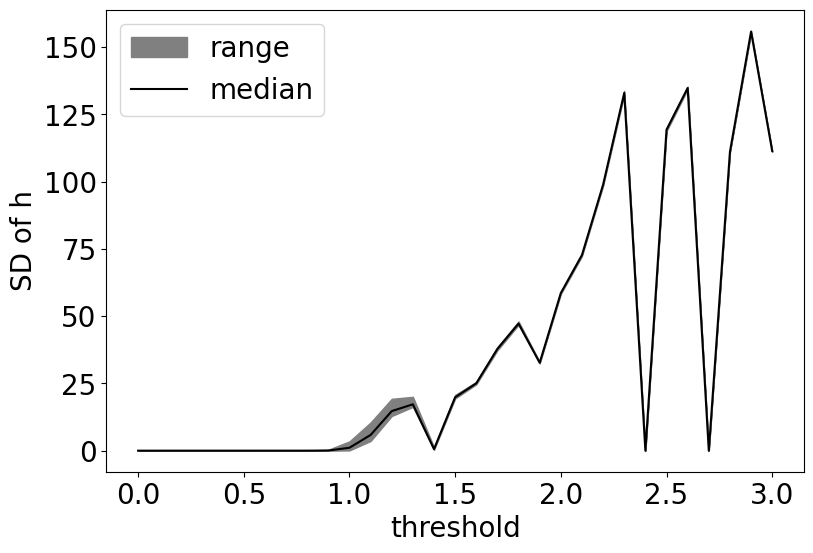

In [124]:
std_h = model.h.std(dim=0)
min_std_h = torch.min(std_h, dim=-1).values
median_std_h = torch.median(std_h, dim=-1).values
max_std_h = torch.max(std_h, dim=-1).values
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
ax.fill_between( depytorch(threshold), depytorch(min_std_h), depytorch(max_std_h), color=[0.5, 0.5, 0.5], label='range' )
ax.plot( depytorch(threshold), depytorch(median_std_h), color=[0.0, 0.0, 0.0], label='median' )
ax.set_xlabel('threshold')
ax.set_ylabel('SD of h')
ax.legend()

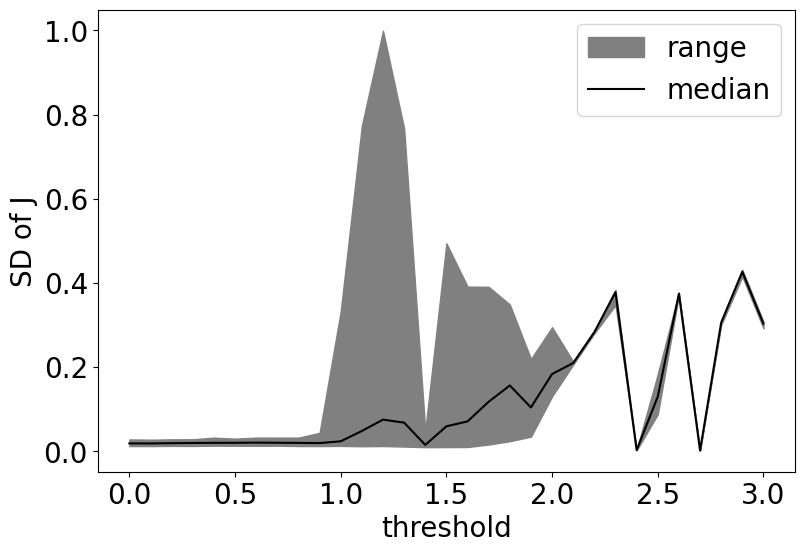

In [125]:
std_J = model.J.std(dim=0)[:,triu_rows,triu_cols]
min_std_J = torch.min(std_J, dim=-1).values
median_std_J = torch.median(std_J, dim=-1).values
max_std_J = torch.max(std_J, dim=-1).values
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
ax.fill_between( depytorch(threshold), depytorch(min_std_J), depytorch(max_std_J), color=[0.5, 0.5, 0.5], label='range' )
ax.plot( depytorch(threshold), depytorch(median_std_J), color=[0.0, 0.0, 0.0], label='median' )
ax.set_xlabel('threshold')
ax.set_ylabel('SD of J')
ax.legend()

In [128]:
num_replicas = model.h.size(dim=0)
num_thresholds = model.h.size(dim=1)
rep_corr_triu_rows, rep_corr_triu_cols = isingmodellight.get_triu_indices_for_products(num_nodes=num_replicas, device=model.h.device)
# Are h parameters proportional to each other in one replica versus another?
# In corrcoef, rows are variables, and columns are observations.
# We want each replica to be a variable and each node to be an observation, so we do not need to take the transpose.
h_replica_corr = torch.stack(  [ torch.corrcoef( model.h[:,thresh_index,:] ) for thresh_index in range(num_thresholds) ], dim=0  )[:,rep_corr_triu_rows, rep_corr_triu_cols]
print( h_replica_corr.size() )

torch.Size([31, 5050])


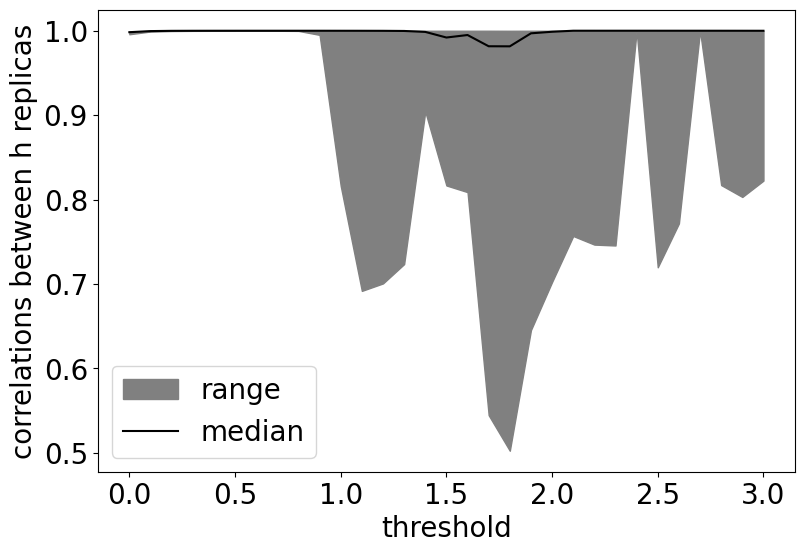

In [129]:
min_h_replica_corr = torch.min(h_replica_corr, dim=-1).values
median_h_replica_corr = torch.median(h_replica_corr, dim=-1).values
max_h_replica_corr = torch.max(h_replica_corr, dim=-1).values
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
ax.fill_between( depytorch(threshold), depytorch(min_h_replica_corr), depytorch(max_h_replica_corr), color=[0.5, 0.5, 0.5], label='range' )
ax.plot( depytorch(threshold), depytorch(median_h_replica_corr), color=[0.0, 0.0, 0.0], label='median' )
ax.set_xlabel('threshold')
ax.set_ylabel('correlations between h replicas')
ax.legend()

In [130]:
num_replicas = model.J.size(dim=0)
num_thresholds = model.J.size(dim=1)
rep_corr_triu_rows, rep_corr_triu_cols = isingmodellight.get_triu_indices_for_products(num_nodes=num_replicas, device=model.J.device)
# Are h parameters proportional to each other in one replica versus another?
# In corrcoef, rows are variables, and columns are observations.
# We want each replica to be a variable and each node to be an observation, so we do not need to take the transpose.
J_replica_corr = torch.stack(  [ torch.corrcoef( model.J[:,thresh_index,triu_rows,triu_cols] ) for thresh_index in range(num_thresholds) ], dim=0  )[:,rep_corr_triu_rows, rep_corr_triu_cols]
print( J_replica_corr.size() )

torch.Size([31, 5050])


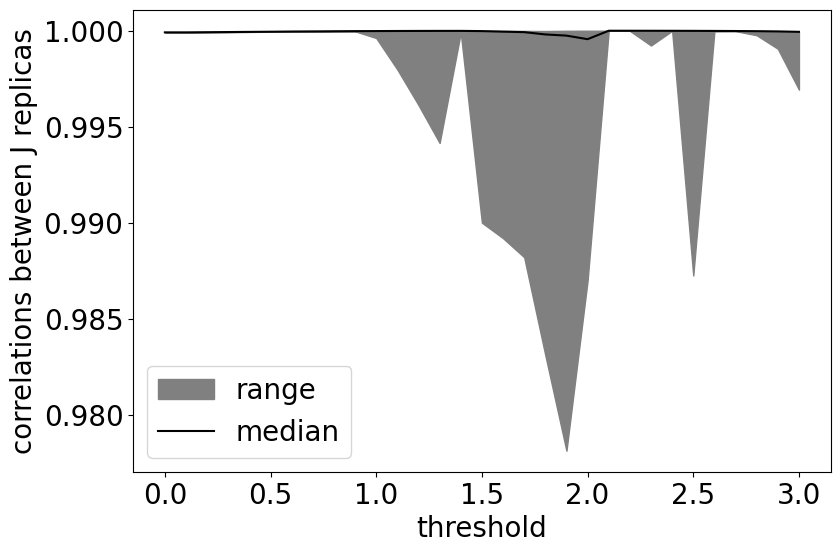

In [131]:
min_J_replica_corr = torch.min(J_replica_corr, dim=-1).values
median_J_replica_corr = torch.median(J_replica_corr, dim=-1).values
max_J_replica_corr = torch.max(J_replica_corr, dim=-1).values
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
ax.fill_between( depytorch(threshold), depytorch(min_J_replica_corr), depytorch(max_J_replica_corr), color=[0.5, 0.5, 0.5], label='range' )
ax.plot( depytorch(threshold), depytorch(median_J_replica_corr), color=[0.0, 0.0, 0.0], label='median' )
ax.set_xlabel('threshold')
ax.set_ylabel('correlations between J replicas')
ax.legend()

In [28]:
threshold_index = get_closest_match(values=threshold, target=1.0)
selected_h = model.h[:,threshold_index,:].mean(dim=0)
selected_J = model.J[:,threshold_index,:,:].mean(dim=0)

[]

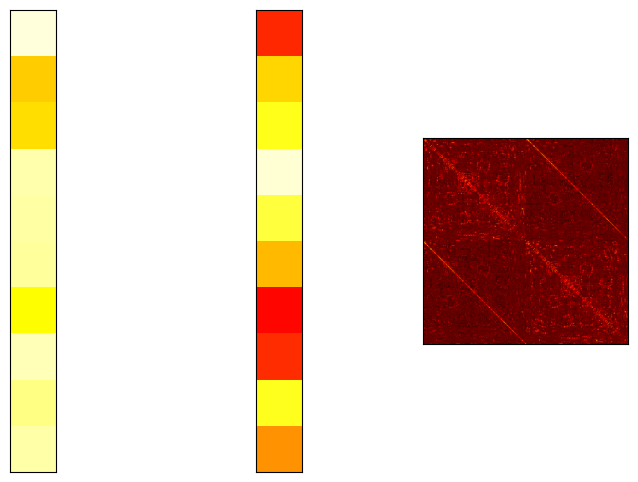

In [33]:
cmap = 'hot'
total_h_min = selected_h.min().item()
total_h_max = selected_h.max().item()
fig, axs = plt.subplots( nrows=1, ncols=3, figsize=(9, 6) )
axs[0].imshow(  depytorch( selected_h[:10].unsqueeze(dim=-1) ), cmap=cmap, vmin=total_h_min, vmax=total_h_max  )
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].imshow(  depytorch( selected_h[-10:].unsqueeze(dim=-1) ), cmap=cmap, vmin=total_h_min, vmax=total_h_max  )
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].imshow( depytorch(selected_J), cmap=cmap )
axs[2].set_xticks([])
axs[2].set_yticks([])

In [16]:
min_beta = 1e-09
max_beta = 0.025
num_beta = 101
beta = torch.linspace(start=min_beta, end=max_beta, steps=num_beta, dtype=float_type, device=device)

In [17]:
model_string = f'light_group_{data_string}_betas_{num_beta}_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_20000_test_beta_min_{min_beta:.3g}_max_{max_beta:.3g}_sim_steps_120000'
sim_mean_state = torch.load( os.path.join(file_dir, f'sim_state_mean_{model_string}.pt'), weights_only=False )
print( sim_mean_state.size() )
sim_mean_state_product = torch.load( os.path.join(file_dir, f'sim_state_product_mean_{model_string}.pt'), weights_only=False )
print( sim_mean_state_product.size() )

torch.Size([101, 31, 360])
torch.Size([101, 31, 360, 360])


In [18]:
fc_corr = torch.load( os.path.join(other_file_dir, f'fc_corr_{model_string}.pt'), weights_only=False )
print( fc_corr.size() )
selected_fc_corr = fc_corr[:,threshold_index]
beta_index = torch.argmax(selected_fc_corr)
selected_fc_corr = selected_fc_corr[beta_index]
print( selected_fc_corr.item() )

torch.Size([101, 31])
0.9602732062339783


In [19]:
sim_selected_mean_state = sim_mean_state[beta_index,threshold_index,:]
sim_selected_mean_state_product = sim_mean_state_product[beta_index,threshold_index,:,:]

In [20]:
sim_selected_std = torch.sqrt( 1 - sim_selected_mean_state.square() )
sim_selected_cov = sim_selected_mean_state_product - sim_selected_mean_state.unsqueeze(dim=1) * sim_selected_mean_state.unsqueeze(dim=0)
sim_selected_fc = sim_selected_cov/( sim_selected_std.unsqueeze(dim=1) * sim_selected_std.unsqueeze(dim=0) )
print( sim_selected_fc.size() )

torch.Size([360, 360])


In [22]:
num_nodes = sim_selected_fc.size(dim=-1)
triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=num_nodes, device=device )
selected_fc_triu = selected_fc[triu_rows,triu_cols]
sim_selected_fc_triu = sim_selected_fc[triu_rows,triu_cols]

Text(0, 0.5, 'sim FC')

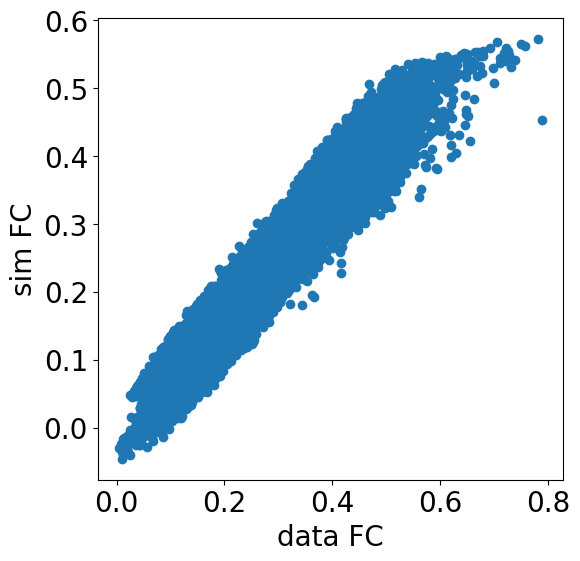

In [23]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 6) )
axs.scatter( depytorch(selected_fc_triu), depytorch(sim_selected_fc_triu) )
axs.set_xlabel('data FC')
axs.set_ylabel('sim FC')

sim FC=0.904data FC+-0.0227, R^2=0.922, corr.=0.96


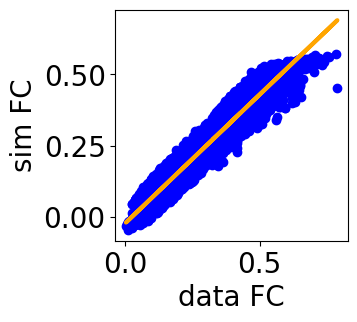

In [38]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(3, 3) )
make_scatter_plot_with_regression_line(ax=ax, feature=selected_fc_triu, param=sim_selected_fc_triu, feature_name='data FC', param_name='sim FC')

[]

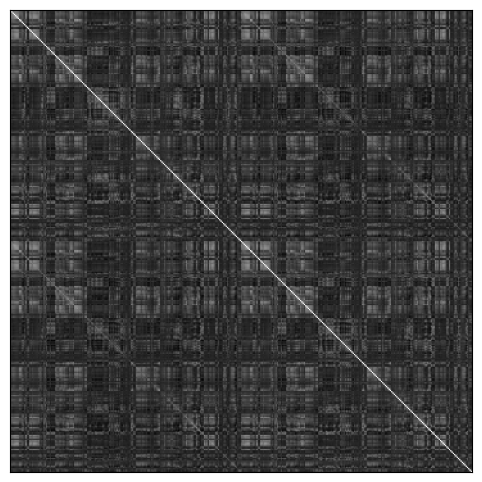

In [25]:
cmap = 'gray'
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.imshow( depytorch(sim_selected_fc), cmap=cmap )
axs.set_xticks([])
axs.set_yticks([])

In [26]:
print(threshold_index)
print(  isingmodellight.get_pairwise_correlation_ut( mat1=selected_fc.unsqueeze(dim=0).unsqueeze(dim=0), mat2=sim_selected_fc.unsqueeze(dim=0).unsqueeze(dim=0), epsilon=0 )  )

tensor(10, device='cuda:0')
tensor([[0.9603]], device='cuda:0')


J=140SC+0.53, R^2=0.264, corr.=0.513


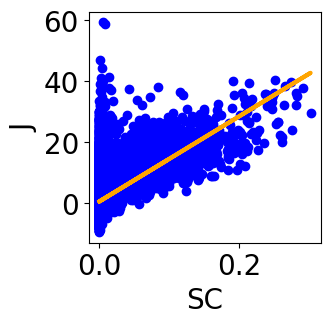

In [39]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(3, 3) )
selected_J_triu = selected_J[triu_rows,triu_cols]
make_scatter_plot_with_regression_line(ax=ax, feature=mean_sc_triu, param=selected_J_triu, feature_name='SC', param_name='J')

In [41]:
mean_myelination = node_features[:,:,1].mean(dim=0)

h=11.6myelination+-17.2, R^2=0.107, corr.=0.326


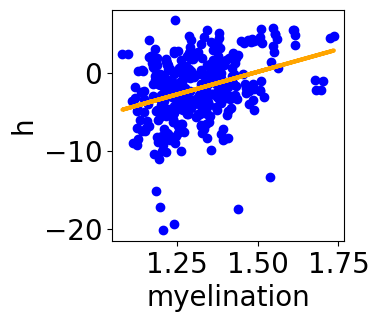

In [42]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(3, 3) )
make_scatter_plot_with_regression_line(ax=ax, feature=mean_myelination, param=selected_h, feature_name='myelination', param_name='h')

In [31]:
num_thresholds = 31
min_threshold = 0.0
max_threshold = 3.0
num_betas = 101
min_beta = 1e-09
max_beta = 0.025
threshold = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=float_type, device=device)
beta = torch.linspace(start=min_beta, end=max_beta, steps=num_betas, dtype=float_type, device=device)
data_string = f'thresholds_{num_thresholds}_min_{min_threshold:.3g}_max_{max_threshold:.3g}'
model_string = f'light_group_{data_string}_betas_{num_betas}_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8'
test_string = f'{model_string}_test_beta_min_{min_beta:.3g}_max_{max_beta:.3g}_sim_steps_120000'

In [32]:
num_thresholds = 31
min_threshold = 0.0
max_threshold = 3.0
num_betas = 101
min_beta = 1e-09
max_beta = 0.025
threshold = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=float_type, device=device)
beta = torch.linspace(start=min_beta, end=max_beta, steps=num_betas, dtype=float_type, device=device)
data_string = f'thresholds_{num_thresholds}_min_{min_threshold:.3g}_max_{max_threshold:.3g}'
# model_string = f'light_group_{data_string}_betas_{num_betas}_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8'
model_string = f'light_group_{data_string}_betas_{num_betas}_min_1e-10_max_1_steps_1200_lr_0.01_beta_updates_9_param_updates_32000'
test_string = f'{model_string}_test_length_120000'

In [33]:
sim_mean_state = torch.load( os.path.join(file_dir, f'sim_state_mean_{test_string}.pt'), weights_only=False )
print( 'sim_mean_state size', sim_mean_state.size() )
sim_mean_state_product = torch.load( os.path.join(file_dir, f'sim_state_product_mean_{test_string}.pt'), weights_only=False )
print( 'sim_mean_state_product size', sim_mean_state_product.size() )

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Ising_model_results_daai\\sim_state_mean_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_1_steps_1200_lr_0.01_beta_updates_9_param_updates_32000_test_length_120000.pt'

In [13]:
data_mean_state = torch.load( os.path.join(file_dir, f'mean_state_{data_string}.pt'), weights_only=False )
print( 'data_mean_state size', data_mean_state.size() )
data_mean_state_product = torch.load( os.path.join(file_dir, f'mean_state_product_{data_string}.pt'), weights_only=False )
print( 'data_mean_state_product size', data_mean_state_product.size() )

data_mean_state size torch.Size([31, 360])
data_mean_state_product size torch.Size([31, 360, 360])


In [20]:
data_fc = isingmodellight.get_fc(state_mean=data_mean_state, state_product_mean=data_mean_state_product, epsilon=0.0)
print( 'data_fc size', data_fc.size() )
sim_fc = isingmodellight.get_fc(state_mean=sim_mean_state, state_product_mean=sim_mean_state_product, epsilon=0.0)
print( 'sim_fc size', sim_fc.size() )
fc_corr = isingmodellight.get_pairwise_correlation_ut( mat1=sim_fc, mat2=data_fc.unsqueeze(dim=0), epsilon=0.0 )
print( 'fc_corr size', fc_corr.size() )

data_fc size torch.Size([31, 360, 360])
sim_fc size torch.Size([101, 31, 360, 360])
fc_corr size torch.Size([101, 31])


In [11]:
num_thresholds = 31
min_threshold = 0.0
max_threshold = 3.0
num_betas = 101
min_beta = 1e-09
max_beta = 0.04
threshold = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=float_type, device=device)
beta = torch.linspace(start=min_beta, end=max_beta, steps=num_betas, dtype=float_type, device=device)
data_string = f'aal_thresholds_{num_thresholds}_min_{min_threshold:.3g}_max_{max_threshold:.3g}'
model_string = f'light_group_init_means_{data_string}_betas_{num_betas}_min_1e-10_max_1_steps_1200_lr_0.01_beta_updates_9'
test_string = f'{model_string}_test_beta_min_{min_beta:.3g}_max_{max_beta:.3g}_sim_steps_120000'

In [50]:
num_thresholds = 31
min_threshold = 0.0
max_threshold = 3.0
num_betas = 101
min_beta = 1e-09
max_beta = 1
threshold = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=float_type, device=device)
beta = torch.linspace(start=min_beta, end=max_beta, steps=num_betas, dtype=float_type, device=device)
data_string = f'thresholds_{num_thresholds}_min_{min_threshold:.3g}_max_{max_threshold:.3g}'
# model_string = f'light_group_{data_string}_betas_{num_betas}_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8'
model_string = f'ising_model_light_aal_group_init_means_{data_string}_betas_{num_betas}_min_1e-10_max_1_steps_1200_lr_0.01_beta_updates_9_param_updates_32000'
test_string = f'{model_string}_test_length_120000'

In [43]:
test_string = 'light_group_init_means_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_1_steps_1200_lr_0.01_beta_updates_8_test_beta_min_1e-09_max_0.05_sim_steps_120000'

In [44]:
fc_corr_file = os.path.join(file_dir, f'fc_corr_{test_string}.pt')
fc_corr = torch.load(fc_corr_file, weights_only=False)
print( f'loaded {fc_corr_file}', fc_corr.size() )

loaded E:\Ising_model_results_daai\fc_corr_light_group_init_means_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_1_steps_1200_lr_0.01_beta_updates_8_test_beta_min_1e-09_max_0.05_sim_steps_120000.pt torch.Size([101, 31])


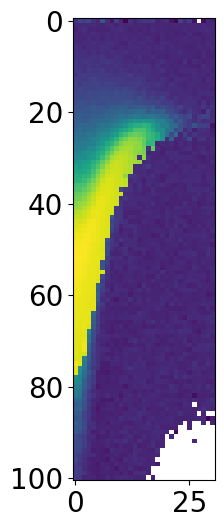

In [36]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(6, 6) )
ax.imshow( depytorch(fc_corr) )

In [37]:
max_index = get_closest_match(values=beta, target=max_beta)
fc_corr_no_nans = fc_corr.clone()
fc_corr_no_nans[ torch.isnan(fc_corr_no_nans) ] = -1.0
best_fc_corr_at_threshold, best_fc_corr_at_threshold_indices = torch.max(fc_corr_no_nans[:max_index,:], dim=0)
best_beta_at_threshold = beta[best_fc_corr_at_threshold_indices]

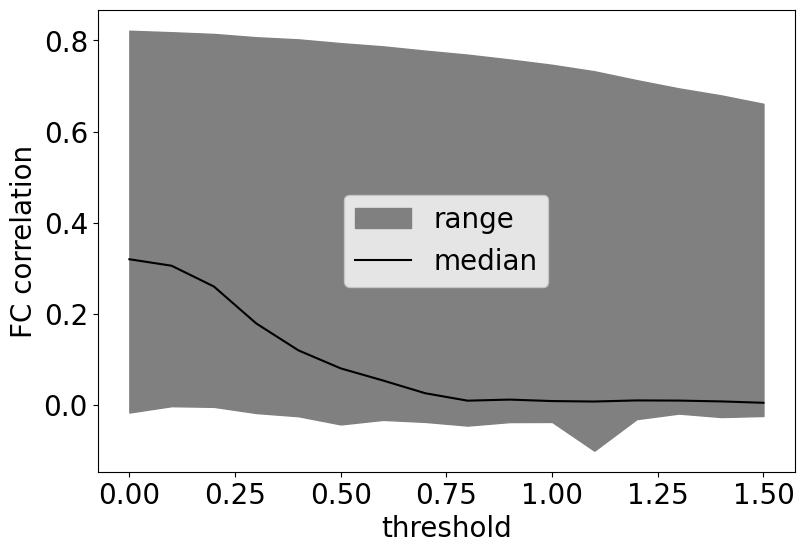

In [38]:
min_fc_corr = torch.min(fc_corr, dim=0).values
median_fc_corr = torch.median(fc_corr, dim=0).values
max_fc_corr = torch.max(fc_corr, dim=0).values
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
ax.fill_between( depytorch(threshold), depytorch(min_fc_corr), depytorch(max_fc_corr), color=[0.5, 0.5, 0.5], label='range' )
ax.plot( depytorch(threshold), depytorch(median_fc_corr), color=[0.0, 0.0, 0.0], label='median' )
ax.set_xlabel('threshold')
ax.set_ylabel('FC correlation')
ax.legend()

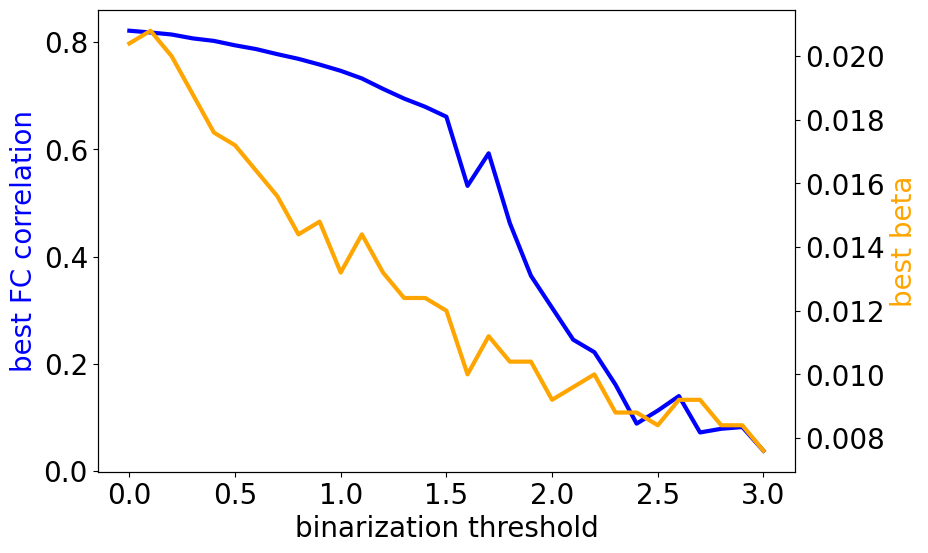

In [39]:
fc_color = 'blue'
beta_color = 'orange'
fig, ax_fc = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
ax_beta = ax_fc.twinx()
ax_fc.set_xlabel('binarization threshold')
ax_fc.plot( depytorch(threshold), depytorch(best_fc_corr_at_threshold), label='FC correlation', linewidth=line_width, color=fc_color )
ax_fc.set_ylabel('best FC correlation')
ax_fc.yaxis.label.set_color(fc_color)
ax_beta.plot( depytorch(threshold), depytorch(best_beta_at_threshold), label='beta', linewidth=line_width, color=beta_color )
ax_beta.set_ylabel('best beta')
ax_beta.yaxis.label.set_color(beta_color)
# fig.legend()
plt.show()

In [40]:
selected_index = get_closest_match(values=threshold, target=1.6)
selected_threshold = threshold[selected_index]
selected_beta = best_beta_at_threshold[selected_index]
selected_fc_corr = best_fc_corr_at_threshold[selected_index]
print(f'The best beta {selected_beta:.3g} for threshold {selected_threshold:.3g} yields FC correlation {selected_fc_corr:.3g}.')

The best beta 0.01 for threshold 1.6 yields FC correlation 0.532.


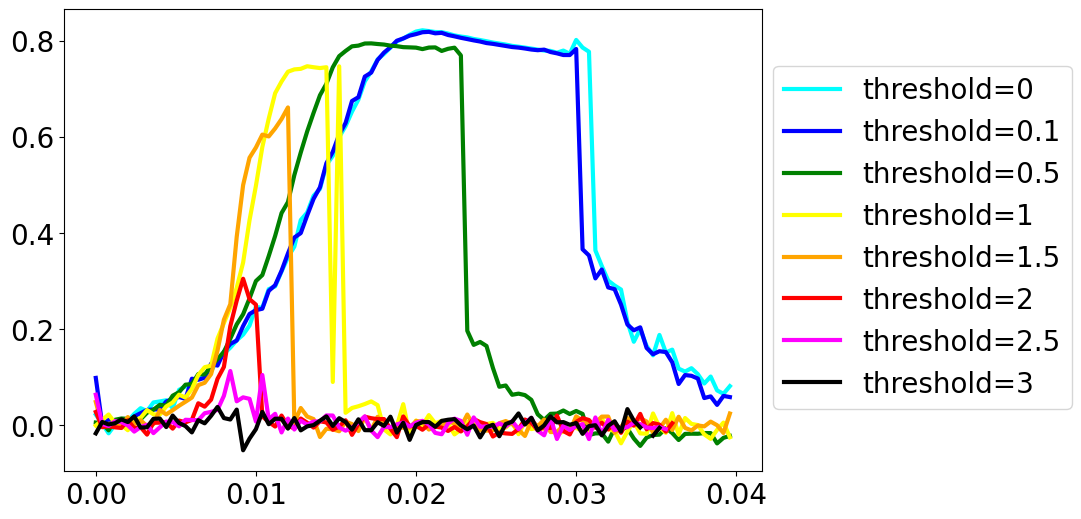

In [41]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
min_index = get_closest_match(values=beta, target=min_beta)
max_index = get_closest_match(values=beta, target=max_beta)
beta_np = depytorch(beta[min_index:max_index])
fc_corr_np = depytorch(fc_corr[min_index:max_index,:])
for target_threshold, threshold_color in zip([0.0, 0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0],['cyan','blue','green','yellow','orange','red','magenta','black']):
    selected_index = get_closest_match(values=threshold, target=target_threshold)
    selected_threshold = threshold[selected_index]
    ax.plot( beta_np, fc_corr_np[:,selected_index], label=f'threshold={selected_threshold:.3g}', linewidth=line_width, color=threshold_color )
fig.legend( loc='center right', bbox_to_anchor=(1.26, 0.5) )

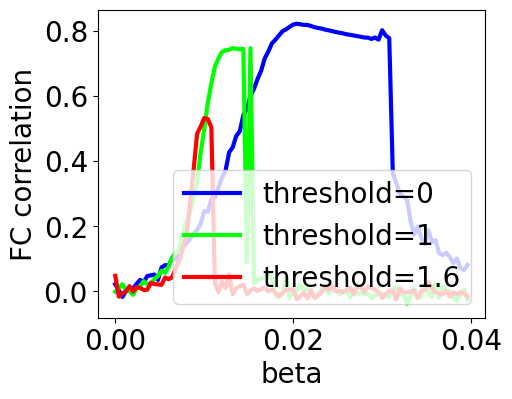

In [61]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
min_index = get_closest_match(values=beta, target=min_beta)
max_index = get_closest_match(values=beta, target=max_beta)
beta_np = depytorch(beta[min_index:max_index])
fc_corr_np = depytorch(fc_corr[min_index:max_index,:])
for target_threshold, threshold_color in zip([0.0, 1.0, 1.6],['blue',[0.0, 1.0, 0.0],'red']):
    selected_index = get_closest_match(values=threshold, target=target_threshold)
    selected_threshold = threshold[selected_index]
    ax.plot( beta_np, fc_corr_np[:,selected_index], label=f'threshold={selected_threshold:.3g}', linewidth=line_width, color=threshold_color )
ax.set_xlabel('beta')
ax.set_ylabel('FC correlation')
# fig.legend( loc='center right', bbox_to_anchor=(1.26, 0.5) )
ax.legend(loc='lower right')

In [47]:
cov_rmse_file = os.path.join(file_dir, f'cov_rmse_{test_string}.pt')
cov_rmse = torch.load(cov_rmse_file, weights_only=False)
print( f'loaded {cov_rmse_file}', cov_rmse.size() )

loaded E:\Ising_model_results_daai\cov_rmse_light_group_init_means_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_1_steps_1200_lr_0.01_beta_updates_8_test_beta_min_1e-09_max_0.05_sim_steps_120000.pt torch.Size([101, 31])


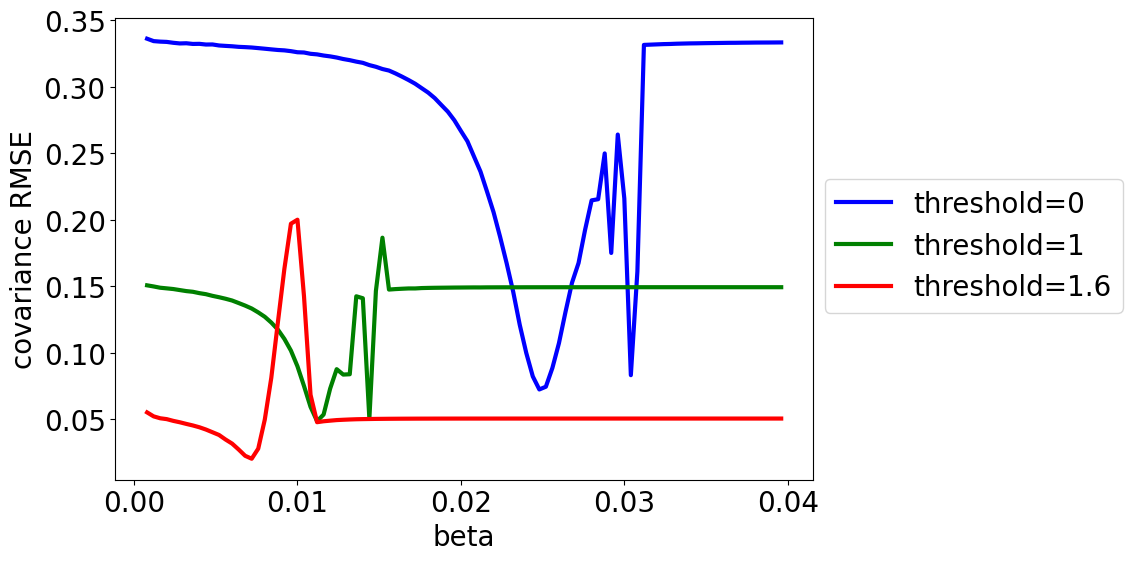

In [49]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
min_index = get_closest_match(values=beta, target=0.001)
max_index = get_closest_match(values=beta, target=max_beta)
beta_np = depytorch(beta[min_index:max_index])
cov_rmse_np = depytorch(cov_rmse[min_index:max_index,:])
for target_threshold, threshold_color in zip([0.0, 1.0, 1.6],['blue','green','red']):
    selected_index = get_closest_match(values=threshold, target=target_threshold)
    selected_threshold = threshold[selected_index]
    ax.plot( beta_np, cov_rmse_np[:,selected_index], label=f'threshold={selected_threshold:.3g}', linewidth=line_width, color=threshold_color )
ax.set_xlabel('beta')
ax.set_ylabel('covariance RMSE')
fig.legend( loc='center right', bbox_to_anchor=(1.26, 0.5) )

In [30]:
model_0 = torch.load( os.path.join(other_file_dir, 'ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000.pt'), weights_only=False )
print( model_0.h.size() )
print( model_0.J.size() )

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Ising_model_results_daai\\ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000.pt'

In [12]:
model_1 = torch.load( os.path.join(file_dir, 'ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_40000.pt'), weights_only=False )
print( model_1.h.size() )
print( model_1.J.size() )

torch.Size([5, 837, 360])
torch.Size([5, 837, 360, 360])


In [16]:
num_nodes = model_0.J.size(dim=-1)
triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products(num_nodes=num_nodes, device=model_0.J.device)
mean_h_0 = model_0.h.mean(dim=0)
mean_J_0 = model_0.J.mean(dim=0)[:,triu_rows,triu_cols]
mean_h_1 = model_1.h.mean(dim=0)
mean_J_1 = model_1.J.mean(dim=0)[:,triu_rows,triu_cols]

Text(0, 0.5, 'J (threshold=1)')

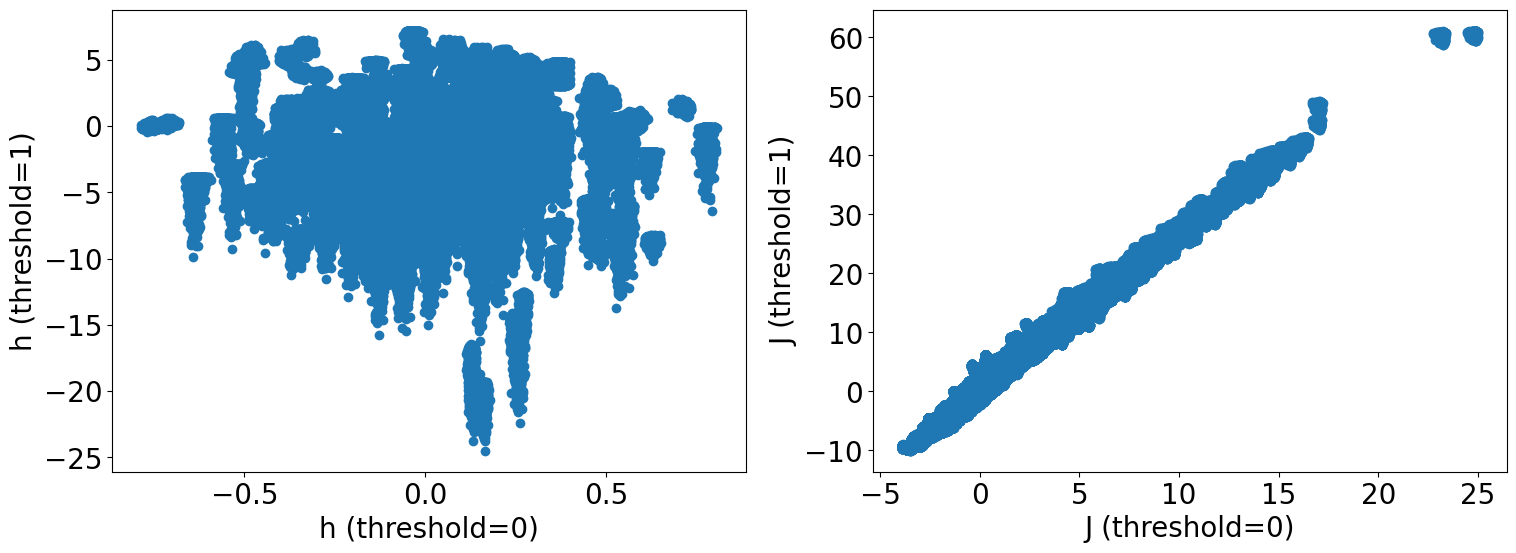

In [28]:
fig, axs = plt.subplots( nrows=1, ncols=2, figsize=(18, 6) )
axs[0].scatter(  depytorch( mean_h_0.transpose(dim0=0, dim1=1) ), depytorch( mean_h_1.transpose(dim0=0, dim1=1) )  )
axs[0].set_xlabel(f'h (threshold=0)')
axs[0].set_ylabel(f'h (threshold=1)')
axs[1].scatter(  depytorch( mean_J_0.transpose(dim0=0, dim1=1) ), depytorch( mean_J_1.transpose(dim0=0, dim1=1) )  )
axs[1].set_xlabel(f'J (threshold=0)')
axs[1].set_ylabel(f'J (threshold=1)')

Text(0, 0.5, 'J (threshold=1)')

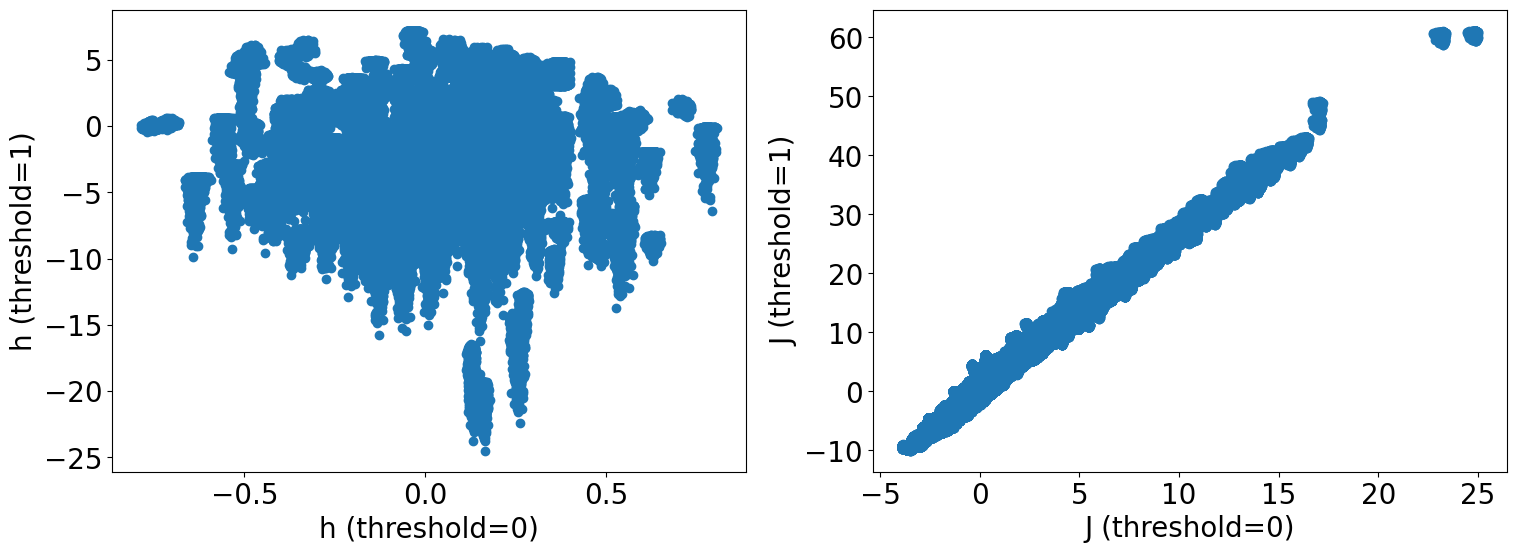

In [29]:
fig, axs = plt.subplots( nrows=1, ncols=2, figsize=(18, 6) )
axs[0].scatter(  depytorch( mean_h_0.flatten() ), depytorch( mean_h_1.flatten() )  )
axs[0].set_xlabel(f'h (threshold=0)')
axs[0].set_ylabel(f'h (threshold=1)')
axs[1].scatter(  depytorch( mean_J_0.flatten() ), depytorch( mean_J_1.flatten() )  )
axs[1].set_xlabel(f'J (threshold=0)')
axs[1].set_ylabel(f'J (threshold=1)')

Text(0, 0.5, 'J (threshold=1)')

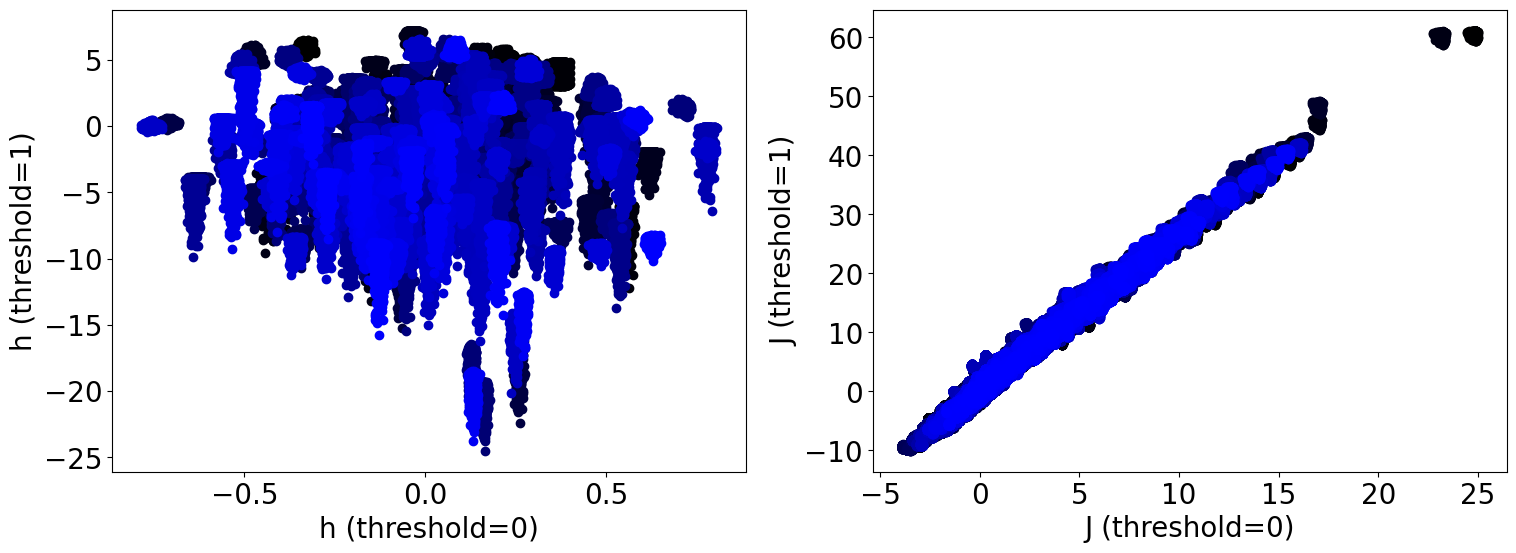

In [30]:
fig, axs = plt.subplots( nrows=1, ncols=2, figsize=(18, 6) )
num_nodes = mean_h_1.size(dim=-1)
for node_index in range(num_nodes):
    axs[0].scatter( depytorch(mean_h_0[:,node_index]), depytorch(mean_h_1[:,node_index]), color=[0.0, 0.0, node_index/num_nodes] )
axs[0].set_xlabel(f'h (threshold=0)')
axs[0].set_ylabel(f'h (threshold=1)')
num_pairs = mean_J_1.size(dim=-1)
for pair_index in range(num_pairs):
    axs[1].scatter( depytorch(mean_J_0[:,pair_index]), depytorch(mean_J_1[:,pair_index]), color=[0.0, 0.0, pair_index/num_pairs] )
axs[1].set_xlabel(f'J (threshold=0)')
axs[1].set_ylabel(f'J (threshold=1)')

In [20]:
h_h_correlation = isingmodellight.get_pairwise_correlation( mat1=mean_h_0.flatten(), mat2=mean_h_1.flatten(), epsilon=0.0, dim=0 )
print(f'The correlation between individual h at threshold=0 and individual h at threshold=1 is {h_h_correlation:.3g}.')
J_J_correlation = isingmodellight.get_pairwise_correlation( mat1=mean_J_0.flatten(), mat2=mean_J_1.flatten(), epsilon=0.0, dim=0 )
print(f'The correlation between individual J at threshold=0 and individual J at threshold=1 is {J_J_correlation:.3g}.')

The correlation between individual h at threshold=0 and individual h at threshold=1 is -0.0108.
The correlation between individual J at threshold=0 and individual J at threshold=1 is 0.989.


In [21]:
h_h_correlation_individual = isingmodellight.get_pairwise_correlation( mat1=mean_h_0, mat2=mean_h_1, epsilon=0.0, dim=-1 )
print( h_h_correlation_individual.size() )
# print(f'The correlation between individual h at threshold=0 and individual h at threshold=1 is {h_h_correlation:.3g}.')
J_J_correlation_individual = isingmodellight.get_pairwise_correlation( mat1=mean_J_0, mat2=mean_J_1, epsilon=0.0, dim=-1 )
# print(f'The correlation between individual J at threshold=0 and individual J at threshold=1 is {J_J_correlation:.3g}.')
print( J_J_correlation_individual.size() )

torch.Size([837])
torch.Size([837])


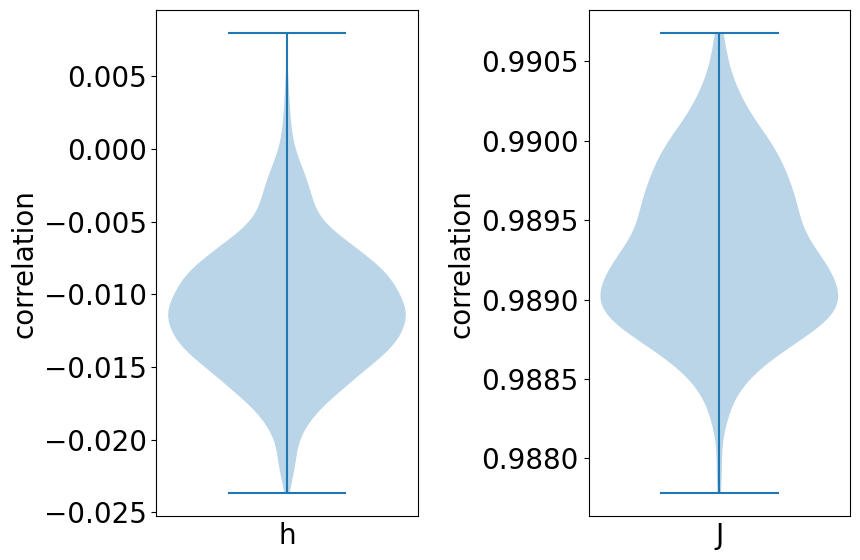

In [26]:
fig, axs = plt.subplots( nrows=1, ncols=2, figsize=(9, 6) )
axs[0].violinplot( depytorch(h_h_correlation_individual) )
axs[0].set_ylabel('correlation')
axs[0].set_xticks([])
axs[0].set_xlabel('h')
axs[1].violinplot( depytorch(J_J_correlation_individual) )
axs[1].set_ylabel('correlation')
axs[1].set_xticks([])
axs[1].set_xlabel('J')
fig.tight_layout()

In [27]:
print(f'The range of correlations between corresponding h values of individual models at thresholds 0 and 1 is [{h_h_correlation_individual.min():.3g}, {h_h_correlation_individual.max():.3g}].')
print(f'The range of correlations between corresponding J values of individual models at thresholds 0 and 1 is [{J_J_correlation_individual.min():.3g}, {J_J_correlation_individual.max():.3g}].')

The range of correlations between corresponding h values of individual models at thresholds 0 and 1 is [-0.0237, 0.00798].
The range of correlations between corresponding J values of individual models at thresholds 0 and 1 is [0.988, 0.991].


In [32]:
h_std_rep_0 = model_0.h.std(dim=0)
h_std_rep_1 = model_1.h.std(dim=0)
print( 'h_std_rep_1 size', h_std_rep_1.size() )
h_mean_0 = model_0.h.mean(dim=0)
h_mean_1 = model_1.h.mean(dim=0)
print( 'h_mean_1 size', h_mean_1.size() )
h_std_subj_0 = h_mean_0.std(dim=0)
h_std_subj_1 = h_mean_1.std(dim=0)
print( 'h_std_subj_1 size', h_std_subj_1.size() )
h_mean_mean_0 = h_mean_0.mean(dim=0)
h_mean_mean_1 = h_mean_1.mean(dim=0)
print( 'h_mean_mean_1 size', h_mean_mean_1.size() )
h_std_node_0 = h_mean_mean_0.std(dim=0)
h_std_node_1 = h_mean_mean_1.std(dim=0)
print( 'h_std_node_1 size', h_std_node_1.size() )

h_std_rep_1 size torch.Size([837, 360])
h_mean_1 size torch.Size([837, 360])
h_std_subj_1 size torch.Size([360])
h_mean_mean_1 size torch.Size([360])
h_std_node_1 size torch.Size([])


In [33]:
J_0_triu = model_0.J[:,:,triu_rows,triu_cols]
J_1_triu = model_1.J[:,:,triu_rows,triu_cols]
J_std_rep_0 = J_0_triu.std(dim=0)
J_std_rep_1 = J_1_triu.std(dim=0)
print( 'J_std_rep_1 size', J_std_rep_1.size() )
J_mean_0 = J_0_triu.mean(dim=0)
J_mean_1 = J_1_triu.mean(dim=0)
print( 'J_mean_1 size', J_mean_1.size() )
J_std_subj_0 = J_mean_0.std(dim=0)
J_std_subj_1 = J_mean_1.std(dim=0)
print( 'J_std_subj_1 size', J_std_subj_1.size() )
J_mean_mean_0 = J_mean_0.mean(dim=0)
J_mean_mean_1 = J_mean_1.mean(dim=0)
print( 'J_mean_mean_1 size', J_mean_mean_1.size() )
J_std_edge_0 = J_mean_mean_0.std(dim=0)
J_std_edge_1 = J_mean_mean_1.std(dim=0)
print( 'J_std_edge_1 size', J_std_edge_1.size() )

J_std_rep_1 size torch.Size([837, 64620])
J_mean_1 size torch.Size([837, 64620])
J_std_subj_1 size torch.Size([64620])
J_mean_mean_1 size torch.Size([64620])
J_std_edge_1 size torch.Size([])


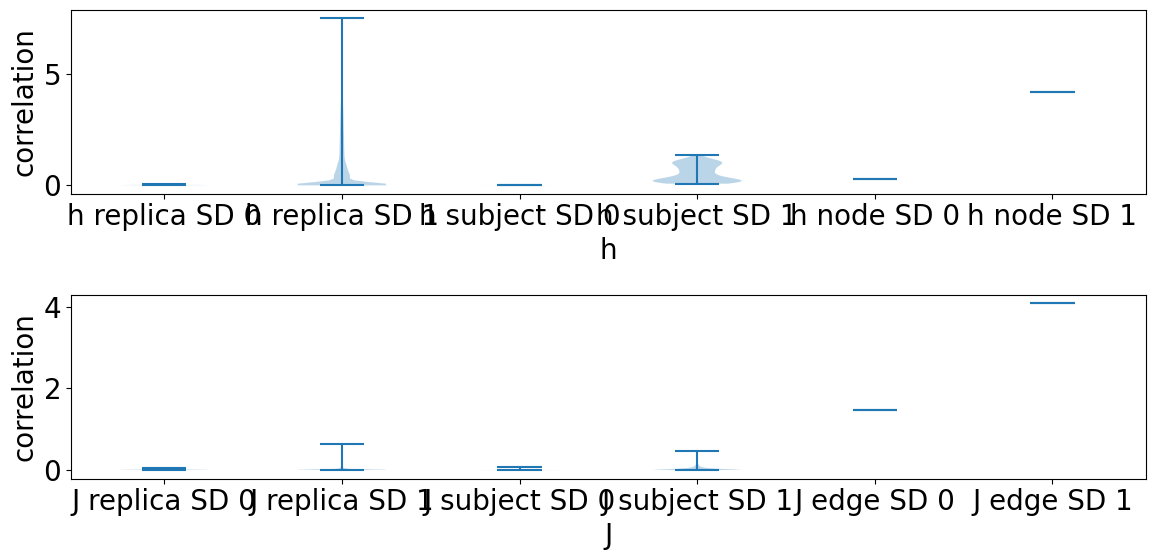

In [37]:
fig, axs = plt.subplots( nrows=2, ncols=1, figsize=(12, 6) )
violin_pos = range(6)
axs[0].violinplot([ depytorch(h_std_rep_0).flatten(), depytorch(h_std_rep_1).flatten(), depytorch(h_std_subj_0), depytorch(h_std_subj_1), depytorch(h_std_node_0), depytorch(h_std_node_1) ], positions=violin_pos)
axs[0].set_ylabel('correlation')
axs[0].set_xticks(violin_pos)
axs[0].set_xticklabels(['h replica SD 0', 'h replica SD 1', 'h subject SD 0', 'h subject SD 1', 'h node SD 0', 'h node SD 1'])
axs[0].set_xlabel('h')
axs[1].violinplot([ depytorch(J_std_rep_0).flatten(), depytorch(J_std_rep_1).flatten(), depytorch(J_std_subj_0), depytorch(J_std_subj_1), depytorch(J_std_edge_0), depytorch(J_std_edge_1) ], positions=violin_pos)
axs[1].set_ylabel('correlation')
axs[1].set_xticks(violin_pos)
axs[1].set_xticklabels(['J replica SD 0', 'J replica SD 1', 'J subject SD 0', 'J subject SD 1', 'J edge SD 0', 'J edge SD 1'])
axs[1].set_xlabel('J')
fig.tight_layout()

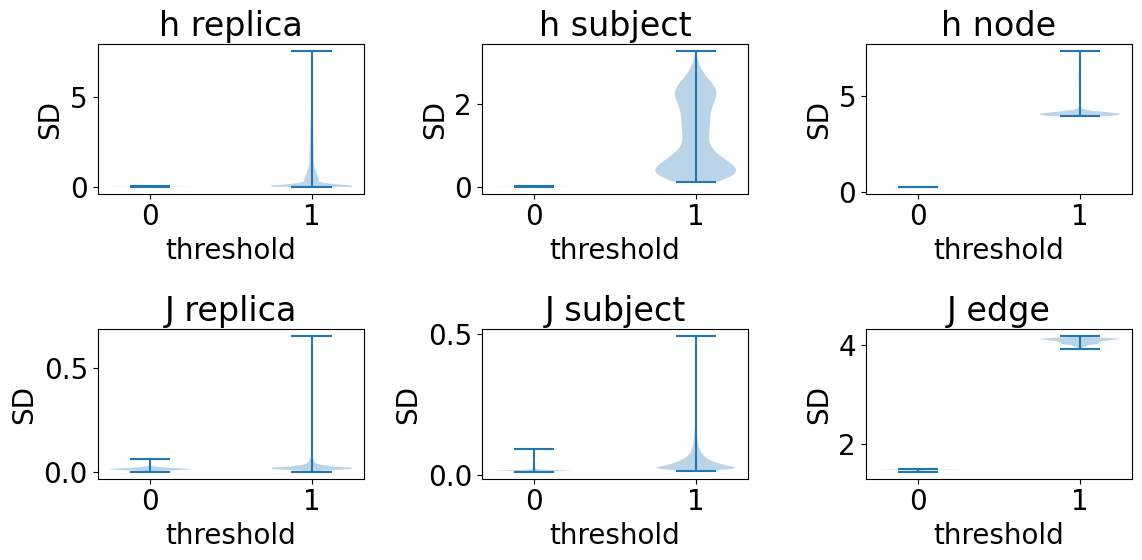

In [41]:
fig, axs = plt.subplots( nrows=2, ncols=3, figsize=(12, 6) )
violin_pos = [0, 1]
for param_pair, param_name, param_location, row_index in zip([ [model_0.h, model_1.h], [J_0_triu, J_1_triu] ], ['h', 'J'], ['node', 'edge'], [0, 1]):
    for std_dim, std_dim_name, col_index in zip([0, 1, 2],['replica', 'subject', param_location],[0, 1, 2]):
        ax = axs[row_index,col_index]
        ax.violinplot([ depytorch( param.std(dim=std_dim).flatten() ) for param in param_pair ], positions=violin_pos)
        ax.set_xlabel('threshold')
        ax.set_ylabel('SD')
        ax.set_title(f'{param_name} {std_dim_name}')
fig.tight_layout()

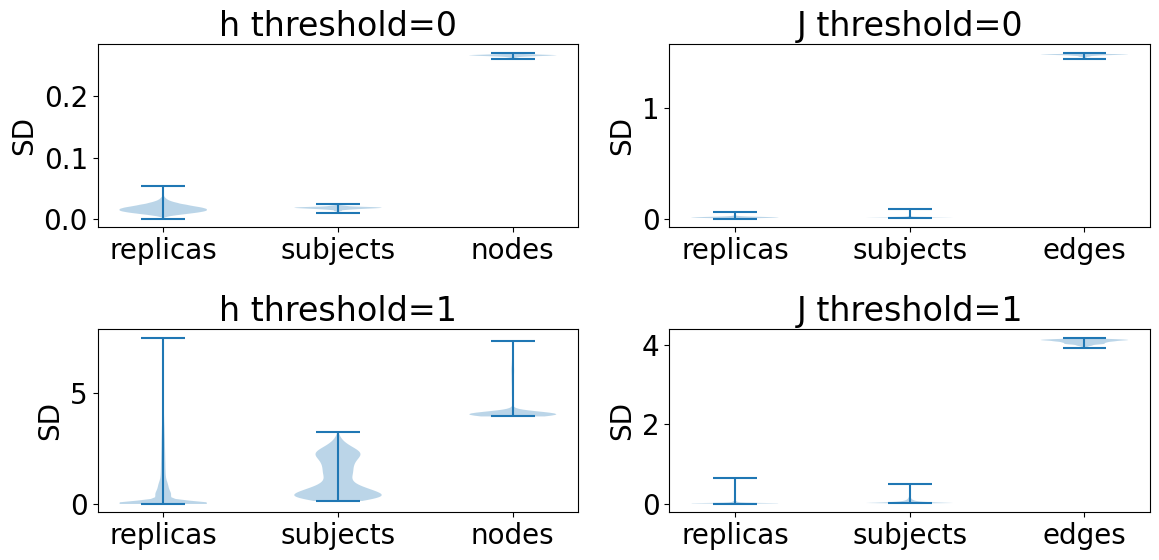

In [42]:
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(12, 6) )
violin_pos = [0, 1, 2]
for row_index, threshold, model in zip([0, 1],[0.0, 1.0],[model_0, model_1]):
    for col_index, param, param_name, param_location in zip([0, 1],[ model.h, model.J[:,:,triu_rows,triu_cols] ],['h', 'J'],['nodes', 'edges']):
        ax = axs[row_index,col_index]
        ax.violinplot(  [ depytorch( param.std(dim=std_dim).flatten() ) for std_dim in [0,1,2] ], positions=violin_pos  )
        ax.set_xticks(violin_pos)
        ax.set_xticklabels(['replicas', 'subjects', param_location])
        ax.set_ylabel('SD')
        ax.set_title(f'{param_name} threshold={threshold:.3g}')
fig.tight_layout()

In [48]:
test_mat = torch.rand( size=(4,3,2,1), dtype=float_type, device=device )
print( test_mat.size() )
test_product = torch.matmul( test_mat, test_mat.transpose(dim0=-2, dim1=-1) )
print( test_product.size() )

torch.Size([4, 3, 2, 1])
torch.Size([4, 3, 2, 2])


In [30]:
num_thresholds = 31
min_threshold = 0.0
max_threshold = 3.0
num_betas = 101
min_beta = 1e-10
max_beta = 0.05
min_updates = 0
max_updates = 40000
update_increment = 1000
fc_corr_summary_file = os.path.join(file_dir, f'summary_fc_corr_all_ising_model_light_group_thresholds_{num_thresholds}_min_{min_threshold:.3g}_max_{max_threshold:.3g}_betas_{num_betas}_min_{min_beta:.3g}_max_{max_beta:.3g}_steps_1200_lr_0.01_beta_updates_8_param_updates_updates_min_{min_updates}_max_{max_updates}_increment_{update_increment}.pt')
fc_corr_summary = torch.load(f=fc_corr_summary_file, weights_only=False)
print( fc_corr_summary.size() )
threshold = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=fc_corr_summary.dtype, device=fc_corr_summary.device)
updates = torch.arange(start=min_updates, end=max_updates+1, step=update_increment, dtype=fc_corr_summary.dtype, device=fc_corr_summary.device)

torch.Size([41, 31, 5])


In [11]:
num_thresholds = 31
min_threshold = 0.0
max_threshold = 3.0
num_betas = 101
min_beta = 1e-10
max_beta = 1.0
min_updates = 0
max_updates = 31000
update_increment = 1000
fc_corr_summary_file = os.path.join(file_dir, f'summary_fc_corr_all_ising_model_light_aal_group_init_means_thresholds_{num_thresholds}_min_{min_threshold:.3g}_max_{max_threshold:.3g}_betas_{num_betas}_min_{min_beta:.3g}_max_{max_beta:.3g}_steps_1200_lr_0.01_beta_updates_9_param_updates_updates_min_{min_updates}_max_{max_updates}_increment_{update_increment}.pt')
fc_corr_summary = torch.load(f=fc_corr_summary_file, weights_only=False)
print( fc_corr_summary.size() )
threshold = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=fc_corr_summary.dtype, device=fc_corr_summary.device)
updates = torch.arange(start=min_updates, end=max_updates+1, step=update_increment, dtype=fc_corr_summary.dtype, device=fc_corr_summary.device)

torch.Size([32, 31, 5])


In [12]:
print( fc_corr_summary[:10,0,:] )

tensor([[0.7950, 0.7944, 0.7957, 0.7941, 0.7958],
        [0.9500, 0.9480, 0.9519, 0.9471, 0.9528],
        [0.9819, 0.9803, 0.9826, 0.9801, 0.9828],
        [0.9904, 0.9892, 0.9908, 0.9887, 0.9909],
        [0.9942, 0.9930, 0.9944, 0.9929, 0.9945],
        [0.9960, 0.9953, 0.9963, 0.9950, 0.9963],
        [0.9970, 0.9959, 0.9973, 0.9953, 0.9974],
        [0.9977, 0.9969, 0.9979, 0.9958, 0.9980],
        [0.9981, 0.9970, 0.9983, 0.9968, 0.9984],
        [0.9985, 0.9976, 0.9986, 0.9974, 0.9986]], device='cuda:0')


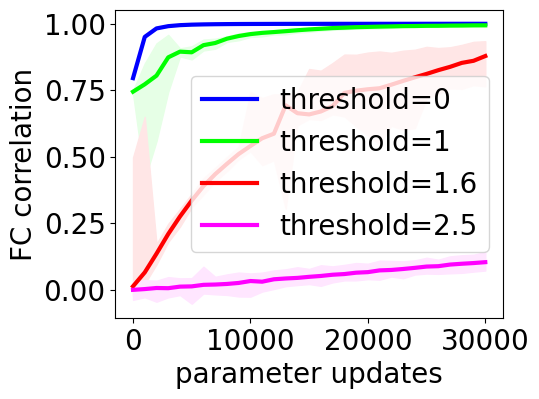

In [13]:
median_col = 0
min_col = -2
max_col = -1
max_updates_to_plot = 35000
max_updates_index = get_closest_match(values=updates, target=max_updates_to_plot)
# selected_indices = [ get_closest_match(values=threshold, target=target) for target in [0.0, 1.0, 1.6, 2.4, 3.0] ]
# selected_colors = [ [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 1.0], [0.0, 0.0, 0.0] ]
selected_indices = [ get_closest_match(values=threshold, target=target) for target in [0.0, 1.0, 1.6, 2.5] ]
selected_colors = [ [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 1.0] ]
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
update_count_np = depytorch(updates[:max_updates_index])
fc_corr_min_np = depytorch(fc_corr_summary[:max_updates_index,:,min_col])
fc_corr_median_np = depytorch(fc_corr_summary[:max_updates_index,:,median_col])
fc_corr_max_np = depytorch(fc_corr_summary[:max_updates_index,:,max_col])
for threshold_index, cval in zip(selected_indices,selected_colors):
    fc_corr_min_for_thresh = fc_corr_min_np[:,threshold_index]
    fc_corr_max_for_thresh = fc_corr_max_np[:,threshold_index]
    selected_threshold = threshold[threshold_index]
    axs.fill_between( update_count_np, fc_corr_min_for_thresh, fc_corr_max_for_thresh, color=[0.9+0.1*c for c in cval])# , label=f'thresh.={selected_threshold:.3g} range'
    # axs.plot( update_count_np, fc_corr_min_for_thresh, color=cval, linestyle='--', linewidth=line_width )
    # axs.plot( update_count_np, fc_corr_max_for_thresh, color=cval, linestyle='--', linewidth=line_width )
    axs.plot( update_count_np, fc_corr_median_np[:,threshold_index], color=cval, linewidth=line_width, label=f'threshold={selected_threshold:.3g}' )# , label=f'thresh.={selected_threshold:.3g} median'
# axs.legend( loc='center right', bbox_to_anchor=(1.46, 0.5) )# , bbox_to_anchor=(1.46, 0.5)
axs.legend()
axs.set_xticks( np.arange(min_updates, max_updates_to_plot, 10000) )
axs.set_xlabel('parameter updates')
axs.set_ylabel('FC correlation')
plt.show()

In [12]:
min_steps = 100
max_steps = 1200
steps_increment = 100
fc_progression = torch.load( f=os.path.join(file_dir, f'fc_corr_all_mean_std_0_steps_min_{min_steps}_max_{max_steps}_inc_{steps_increment}.pt'), weights_only=False )
print( fc_progression.size() )

torch.Size([12, 4, 837])


In [14]:
step = torch.arange(start=min_steps, end=max_steps+1, step=steps_increment, dtype=int_type, device=fc_progression.device)
progression_func = lambda func_handle : func_handle(  func_handle( input=fc_progression, dim=2 ).values, dim=1  ).values
min_fc_corr = progression_func( torch.min )
median_fc_corr = progression_func( torch.median )
max_fc_corr = progression_func( torch.max )

In [16]:
print( min_fc_corr )
print( median_fc_corr )
print( max_fc_corr )

tensor([0.0764, 0.2311, 0.3187, 0.4004, 0.4522, 0.4309, 0.4987, 0.5109, 0.5351,
        0.5377, 0.5453, 0.5490], device='cuda:0')
tensor([0.3617, 0.5002, 0.5852, 0.6441, 0.6911, 0.7284, 0.7557, 0.7778, 0.7967,
        0.8132, 0.8266, 0.8339], device='cuda:0')
tensor([0.6367, 0.7678, 0.8169, 0.8388, 0.8678, 0.8818, 0.8966, 0.9128, 0.9231,
        0.9289, 0.9366, 0.9415], device='cuda:0')


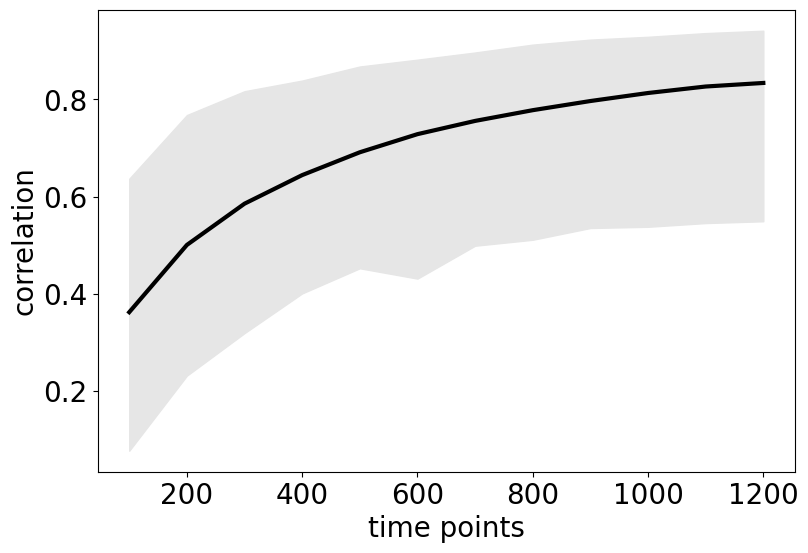

In [19]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
step_count_np = depytorch(step)
fc_corr_min_np = depytorch(min_fc_corr)
fc_corr_median_np = depytorch(median_fc_corr)
fc_corr_max_np = depytorch(max_fc_corr)
cval = [0.0, 0.0, 0.0]
axs.fill_between( step_count_np, fc_corr_min_np, fc_corr_max_np, color=[0.9+0.1*c for c in cval])# , label=f'thresh.={selected_threshold:.3g} range'
axs.plot( step_count_np, fc_corr_median_np, color=cval, linewidth=line_width )# , label=f'thresh.={selected_threshold:.3g} median'
# axs.legend( loc='center right', bbox_to_anchor=(1.46, 0.5) )# , bbox_to_anchor=(1.46, 0.5)
# axs.set_xticks( np.arange(min_updates, max_updates_to_plot, 10000) )
axs.set_xlabel('time points')
axs.set_ylabel('correlation')
plt.show()

torch.Size([12, 4, 837])
torch.Size([12, 4, 837])
torch.Size([12, 4, 837])
torch.Size([12, 4, 837])


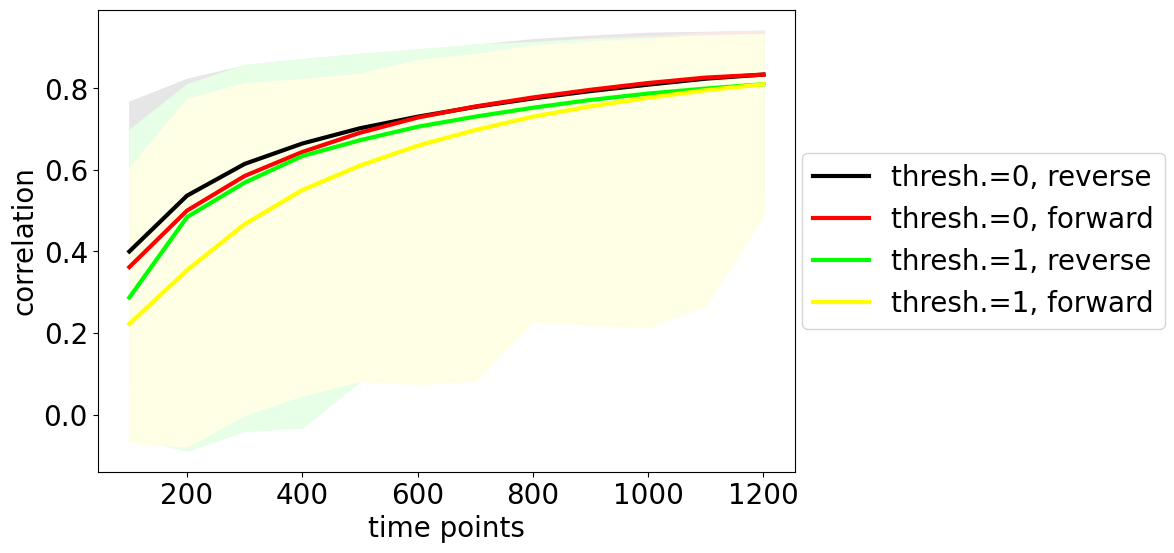

In [28]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
thresholds = [0.0, 1.0]
directions = ['reverse', 'forward']
for threshold in thresholds:
    for direction, dir_cval in zip(directions,[0.0,1.0]):
        fc_progression = torch.load( f=os.path.join(file_dir, f'fc_corr_all_mean_std_{threshold:.3g}_{direction}_steps_min_{min_steps}_max_{max_steps}_inc_{steps_increment}.pt'), weights_only=False )
        print( fc_progression.size() )
        min_fc_corr = progression_func( torch.min )
        median_fc_corr = progression_func( torch.median )
        max_fc_corr = progression_func( torch.max )
        fc_corr_min_np = depytorch(min_fc_corr)
        fc_corr_median_np = depytorch(median_fc_corr)
        fc_corr_max_np = depytorch(max_fc_corr)
        cval = [dir_cval, threshold, 0.0]
        axs.fill_between( step_count_np, fc_corr_min_np, fc_corr_max_np, color=[0.9+0.1*c for c in cval])# , label=f'thresh.={selected_threshold:.3g} range'
        axs.plot( step_count_np, fc_corr_median_np, color=cval, linewidth=line_width, label=f'thresh.={threshold:.3g}, {direction}' )# , label=f'thresh.={selected_threshold:.3g} median'
axs.legend( loc='center right', bbox_to_anchor=(1.55, 0.5) )# , bbox_to_anchor=(1.46, 0.5)
# axs.set_xticks( np.arange(min_updates, max_updates_to_plot, 10000) )
axs.set_xlabel('time points')
axs.set_ylabel('correlation')
plt.show()

torch.Size([1200, 5, 837])
torch.Size([1200, 5, 837])


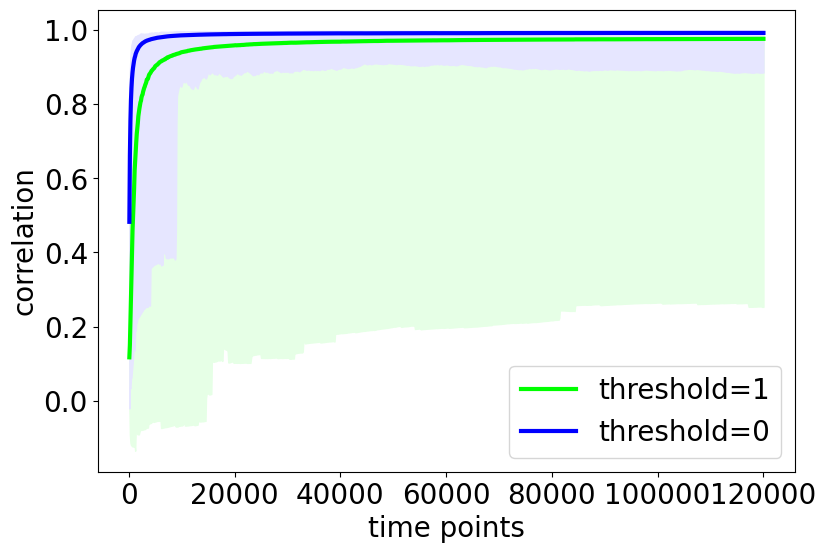

In [34]:
min_steps = 100
max_steps = 120000
step_increment = 100
step = torch.arange(start=min_steps, end=max_steps+1, step=steps_increment, dtype=int_type, device=device)
step_count_np = depytorch(step)
steps_string = f'steps_min_{min_steps}_max_{max_steps}_inc_{step_increment}'
thresholds = [0.0, 1.0]
model_files = [
    f'fc_corr_all_mean_std_{thresholds[0]:.3g}_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000_{steps_string}.pt',
    f'fc_corr_all_mean_std_{thresholds[1]:.3g}_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000_{steps_string}.pt'
]
threshold_colors = [ [0.0, 0.0, 1.0], [0.0, 1.0, 0.0] ]
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
for threshold, model_file, cval in reversed(  list( zip(thresholds, model_files, threshold_colors) )  ):
    fc_progression = torch.load( f=os.path.join(file_dir, model_file), weights_only=False )
    print( fc_progression.size() )
    min_fc_corr = progression_func( torch.min )
    median_fc_corr = progression_func( torch.median )
    max_fc_corr = progression_func( torch.max )
    fc_corr_min_np = depytorch(min_fc_corr)
    fc_corr_median_np = depytorch(median_fc_corr)
    fc_corr_max_np = depytorch(max_fc_corr)
    axs.fill_between( step_count_np, fc_corr_min_np, fc_corr_max_np, color=[0.9+0.1*c for c in cval] )
    axs.plot( step_count_np, fc_corr_median_np, color=cval, linewidth=line_width, label=f'threshold={threshold:.3g}' )# , label=f'thresh.={selected_threshold:.3g} median'
# axs.legend( loc='center right', bbox_to_anchor=(1.46, 0.5) )# , bbox_to_anchor=(1.46, 0.5)
axs.legend( loc='lower right' )# , bbox_to_anchor=(1.46, 0.5)
# axs.set_xticks( np.arange(min_updates, max_updates_to_plot, 10000) )
axs.set_xlabel('time points')
axs.set_ylabel('correlation')
plt.show()

torch.Size([1200, 5, 837])
torch.Size([1200, 5, 837])


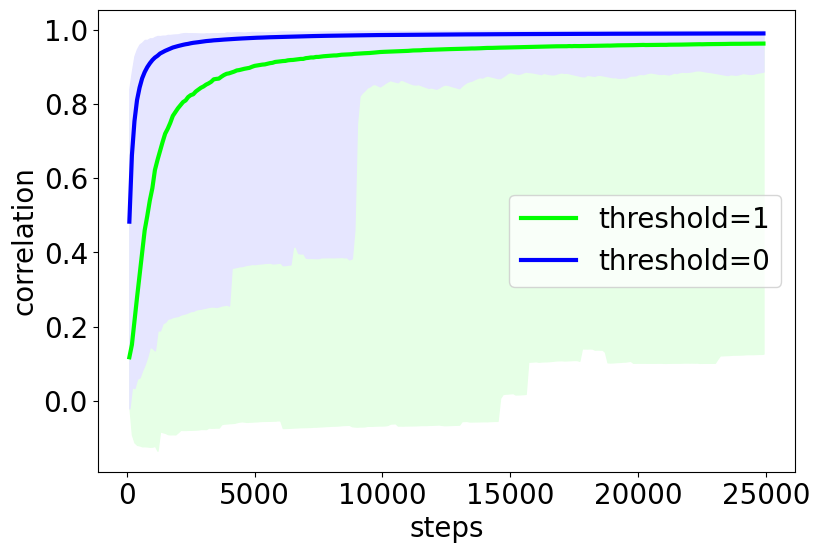

In [71]:
min_steps = 100
max_steps = 120000
max_steps_to_plot = 25000
step_increment = 100
step = torch.arange(start=min_steps, end=max_steps+1, step=steps_increment, dtype=int_type, device=device)
max_step_index = get_closest_match(values=step, target=max_steps_to_plot)
step_count_np = depytorch(step[:max_step_index])
steps_string = f'steps_min_{min_steps}_max_{max_steps}_inc_{step_increment}'
thresholds = [0.0, 1.0]
model_files = [
    f'fc_corr_all_mean_std_{thresholds[0]:.3g}_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000_{steps_string}.pt',
    f'fc_corr_all_mean_std_{thresholds[1]:.3g}_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000_{steps_string}.pt'
]
threshold_colors = [ [0.0, 0.0, 1.0], [0.0, 1.0, 0.0] ]
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
for threshold, model_file, cval in reversed(  list( zip(thresholds, model_files, threshold_colors) )  ):
    fc_progression = torch.load( f=os.path.join(file_dir, model_file), weights_only=False )
    print( fc_progression.size() )
    min_fc_corr = progression_func( torch.min )[:max_step_index]
    median_fc_corr = progression_func( torch.median )[:max_step_index]
    max_fc_corr = progression_func( torch.max )[:max_step_index]
    fc_corr_min_np = depytorch(min_fc_corr)
    fc_corr_median_np = depytorch(median_fc_corr)
    fc_corr_max_np = depytorch(max_fc_corr)
    axs.fill_between( step_count_np, fc_corr_min_np, fc_corr_max_np, color=[0.9+0.1*c for c in cval] )
    axs.plot( step_count_np, fc_corr_median_np, color=cval, linewidth=line_width, label=f'threshold={threshold:.3g}' )# , label=f'thresh.={selected_threshold:.3g} median'
# axs.legend( loc='center right', bbox_to_anchor=(1.46, 0.5) )# , bbox_to_anchor=(1.46, 0.5)
axs.legend( loc='center right' )# , bbox_to_anchor=(1.46, 0.5)
# axs.set_xticks( np.arange(min_updates, max_updates_to_plot, 10000) )
axs.set_xlabel('steps')
axs.set_ylabel('correlation')
plt.show()

torch.Size([3348, 12])
torch.Size([3348, 12])
torch.Size([3348, 12])
torch.Size([3348, 12])


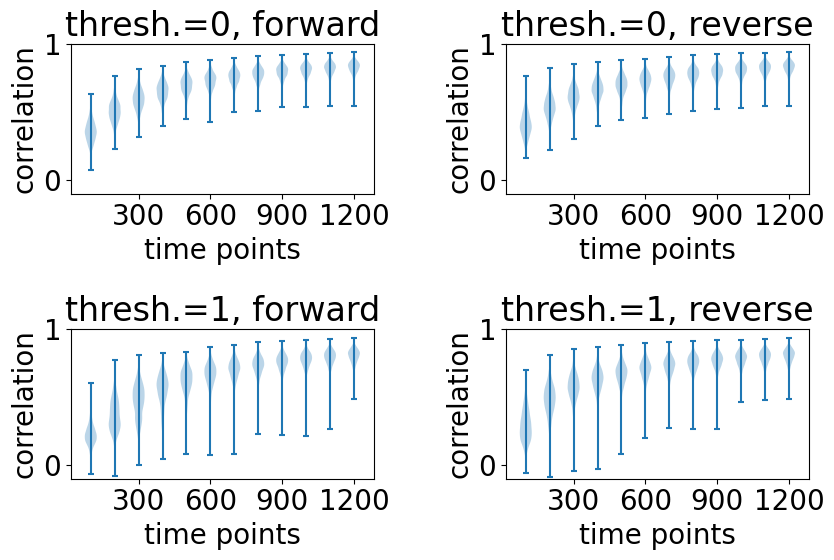

In [55]:
min_steps = 100
max_steps = 1200
step_increment = 100
steps_string = f'steps_min_{min_steps}_max_{max_steps}_inc_{step_increment}'
step = torch.arange(start=min_steps, end=max_steps+1, step=steps_increment, dtype=int_type, device=device)
tick_spacing = 3
num_steps = step.numel()
# tick_indices = range( 0, step.numel(), tick_spacing )
# tick_locations = [t+1 for t in tick_indices]
tick_locations = [num_steps//4, num_steps//2, (3*num_steps)//4, num_steps]
tick_indices = [t-1 for t in tick_locations]
tick_labels = [ f'{s}' for s in step[tick_indices] ]
tick_labels = tick_labels
fig, axs = plt.subplots( nrows=2, ncols=2, figsize=(9, 6) )
for threshold, row_index in zip([0.0, 1.0], [0, 1]):
    for direction, col_index in zip(['forward', 'reverse'], [0, 1]):
        fc_progression_file = os.path.join(file_dir, f'fc_corr_all_mean_std_{threshold:.3g}_{direction}_{steps_string}.pt')
        fc_progression = torch.load(f=fc_progression_file, weights_only=False).flatten(start_dim=1, end_dim=2).transpose(dim0=0, dim1=1)
        print( fc_progression.size() )
        ax = axs[row_index, col_index]
        ax.violinplot( depytorch(fc_progression) )
        ax.set_ylim([-0.1, 1.0])
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(tick_labels)
        ax.set_xlabel('time points')
        ax.set_ylabel('correlation')
        ax.set_title(f'thresh.={threshold:.3g}, {direction}')
plt.tight_layout()
plt.show()

tensor([  1200,   4800,  50000, 120000], device='cuda:0', dtype=torch.int32)
torch.Size([4185, 4])
torch.Size([4185, 4])


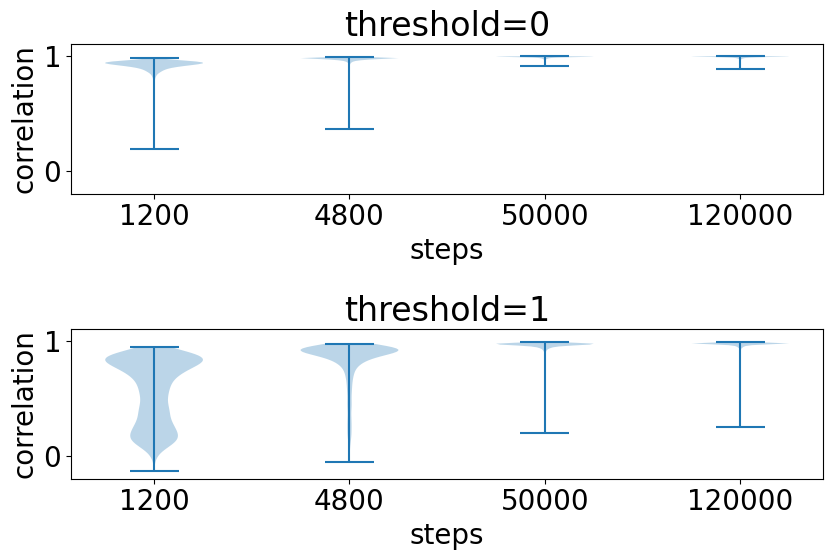

In [70]:
min_steps = 100
max_steps = 120000
step_increment = 100
step = torch.arange(start=min_steps, end=max_steps+1, step=steps_increment, dtype=int_type, device=device)
steps_string = f'steps_min_{min_steps}_max_{max_steps}_inc_{step_increment}'
thresholds = [0.0, 1.0]
fc_corr_files = [
    f'fc_corr_all_mean_std_{thresholds[0]:.3g}_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000_{steps_string}.pt',
    f'fc_corr_all_mean_std_{thresholds[1]:.3g}_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000_{steps_string}.pt'
]
target_steps = [1200, 4800, 50000, 120000]
step_indices = [get_closest_match(values=step, target=sval).item() for sval in target_steps]
selected_steps = step[step_indices]
print(selected_steps)
num_steps = len(target_steps)
step_locations = [sind+1 for sind in range(num_steps)]
step_labels = [f'{sval}' for sval in selected_steps]
fig, axs = plt.subplots( nrows=2, ncols=1, figsize=(9, 6) )
for threshold, fc_corr_file, row_index in zip(thresholds, fc_corr_files, [0, 1]):
    fc_corr_file = os.path.join(file_dir,fc_corr_file)
    fc_corr = torch.load(f=fc_corr_file, weights_only=False).flatten(start_dim=1, end_dim=2).transpose(dim0=0, dim1=1)[:,step_indices]
    print( fc_corr.size() )
    ax = axs[row_index]
    ax.violinplot( depytorch(fc_corr) )
    ax.set_ylim([-0.2, 1.1])
    ax.set_xticks(step_locations)
    ax.set_xticklabels(step_labels)
    ax.set_xlabel('steps')
    ax.set_ylabel('correlation')
    ax.set_title(f'threshold={threshold:.3g}')
plt.tight_layout()
plt.show()

In [63]:
print(step_locations)

[12, 48, 500, 1200]


In [14]:
model_param_string_aal = 'group_init_means_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_1_steps_1200_lr_0.01_beta_updates_8_v2_param_updates_40000'
fc_corr_aal = torch.load( os.path.join(file_dir, f'fc_corr_ising_model_light_{model_param_string_aal}_test_length_120000.pt'), weights_only=False )
print( fc_corr_aal.size() )
fc_corr_aal_mean_h = torch.load( os.path.join(file_dir, f'fc_corr_{model_param_string_aal}h_mean_area_test_length_120000.pt'), weights_only=False )
print( fc_corr_aal_mean_h.size() )

torch.Size([101, 31])
torch.Size([101, 31])


In [15]:
base_color_amplitude = 1.0
red_cval = [base_color_amplitude, 0.0, 0.0]
orange_cval = [base_color_amplitude, base_color_amplitude*0.5, 0.0]
green_cval = [0.0, base_color_amplitude, 0.0]
blue_cval = [0.0, 0.0, base_color_amplitude]

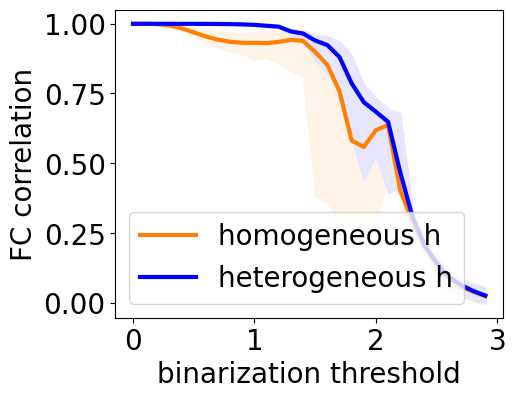

In [17]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
end_thresh = get_closest_match(values=threshold, target=3.0)

line_width = 3.0

threshold_np = depytorch(threshold[:end_thresh])

fc_corr_hom_aal_in_range = fc_corr_aal_mean_h[:,:end_thresh]
fc_corr_hom_min_final = depytorch( fc_corr_hom_aal_in_range.min(dim=0).values )
fc_corr_hom_max_final = depytorch( fc_corr_hom_aal_in_range.max(dim=0).values )
fc_corr_hom_median_final = depytorch( fc_corr_hom_aal_in_range.median(dim=0).values )

cval = orange_cval
axs.fill_between( threshold_np, fc_corr_hom_min_final, fc_corr_hom_max_final, color=[0.9+0.1*c for c in cval])
# axs.plot( threshold_np, fc_corr_min_final, color=cval, linestyle='--', linewidth=line_width )
# axs.plot( threshold_np, fc_corr_max_final, color=cval, linestyle='--', linewidth=line_width )
axs.plot( threshold_np, fc_corr_hom_median_final, color=cval, linewidth=line_width, label=f'homogeneous h' )

fc_corr_aal_in_range = fc_corr_aal[:,:end_thresh]
fc_corr_min_final = depytorch( fc_corr_aal_in_range.min(dim=0).values )
fc_corr_max_final = depytorch( fc_corr_aal_in_range.max(dim=0).values )
fc_corr_median_final = depytorch( fc_corr_aal_in_range.median(dim=0).values )

cval = blue_cval
axs.fill_between( threshold_np, fc_corr_min_final, fc_corr_max_final, color=[0.9+0.1*c for c in cval])
# axs.plot( threshold_np, fc_corr_min_final, color=cval, linestyle='--', linewidth=line_width )
# axs.plot( threshold_np, fc_corr_max_final, color=cval, linestyle='--', linewidth=line_width )
axs.plot( threshold_np, fc_corr_median_final, color=cval, linewidth=line_width, label=f'heterogeneous h' )

axs.legend(loc='lower left')
axs.set_xlabel('binarization threshold')
axs.set_ylabel('FC correlation')
plt.show()

In [69]:
fc_corr_individual_h_0 = torch.load( os.path.join(file_dir, 'fc_corr_all_aal_mean_std_0_medium_init_uncentered_reps_5_beta_min_1e-09_max_0.08_steps_1200_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_64_popt_steps_10000_test_length_120000.pt'), weights_only=False )
fc_corr_mean_h_0 = torch.load( os.path.join(file_dir, 'fc_corr_all_aal_mean_std_0_medium_init_uncentered_reps_5_beta_min_1e-09_max_0.08_steps_1200_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_64_popt_steps_10000h_mean_group_test_length_120000.pt'), weights_only=False )
fc_corr_individual_h_1 = torch.load( os.path.join(file_dir, 'fc_corr_all_aal_mean_std_1_medium_init_uncentered_reps_5_beta_min_1e-09_max_0.03_steps_1200_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_75_popt_steps_40000_test_length_120000.pt'), weights_only=False )
fc_corr_mean_h_1 = torch.load( os.path.join(file_dir, 'fc_corr_all_aal_mean_std_1_medium_init_uncentered_reps_5_beta_min_1e-09_max_0.03_steps_1200_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_75_popt_steps_40000h_mean_group_test_length_120000.pt'), weights_only=False )

In [14]:
# re-did these with the same set of subjects as we used for the Glasser Atlas
fc_corr_individual_h_0 = torch.load( os.path.join(file_dir, 'fc_corr_ising_model_light_all_aal_mean_std_0_medium_init_uncentered_reps_5_beta_min_1e-09_max_0.03_steps_12000_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_64_v2_popt_steps_5000_test_length_120000.pt'), weights_only=False )
fc_corr_mean_h_0 = torch.load( os.path.join(file_dir, 'fc_corr_all_aal_mean_std_0_medium_init_uncentered_reps_5_beta_min_1e-09_max_0.03_steps_12000_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_64_v2_popt_steps_5000h_mean_group_test_length_120000.pt'), weights_only=False )
fc_corr_individual_h_1 = torch.load( os.path.join(file_dir, 'fc_corr_ising_model_light_all_aal_mean_std_1_medium_init_uncentered_reps_5_beta_min_1e-09_max_0.03_steps_12000_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_64_popt_steps_5000_test_length_120000.pt'), weights_only=False )
fc_corr_mean_h_1 = torch.load( os.path.join(file_dir, 'fc_corr_all_aal_mean_std_1_medium_init_uncentered_reps_5_beta_min_1e-09_max_0.03_steps_12000_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_64_popt_steps_5000h_mean_group_test_length_120000.pt'), weights_only=False )

In [16]:
# individualizing from the group model works better
fc_corr_individual_h_0 = torch.load( os.path.join(file_dir, 'fc_corr_group_init_means_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_1_steps_1200_lr_0.01_beta_updates_8_v2_param_updates_40000_to_thresh_0_reps_5_subj_837_individual_updates_15000_test_length_120000.pt'), weights_only=False )
fc_corr_mean_h_0 = torch.load( os.path.join(file_dir, 'fc_corr_group_init_means_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_1_steps_1200_lr_0.01_beta_updates_8_v2_param_updates_40000_to_thresh_0_reps_5_subj_837_individual_updates_15000h_mean_group_test_length_120000.pt'), weights_only=False )
fc_corr_individual_h_1 = torch.load( os.path.join(file_dir, 'fc_corr_group_init_means_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_1_steps_1200_lr_0.01_beta_updates_8_v2_param_updates_40000_to_thresh_1_reps_5_subj_837_individual_updates_12000_test_length_120000.pt'), weights_only=False )
fc_corr_mean_h_1 = torch.load( os.path.join(file_dir, 'fc_corr_group_init_means_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_1_steps_1200_lr_0.01_beta_updates_8_v2_param_updates_40000_to_thresh_1_reps_5_subj_837h_mean_group_test_length_120000.pt'), weights_only=False )

In [17]:
print( fc_corr_individual_h_0.size() )

torch.Size([5, 837])


In [18]:
print_stats(name='FC correlation, threshold=0', values=fc_corr_individual_h_0)
print_stats(name='FC correlation, threshold=0 with mean h', values=fc_corr_mean_h_0)
print_stats(name='FC correlation, threshold=1', values=fc_corr_individual_h_1)
print_stats(name='FC correlation, threshold=1 with mean h', values=fc_corr_mean_h_1)

The distribution of FC correlation, threshold=0 values has median 0.999 with 95% CI [0.996, 0.999] and range [0.984, 0.999].
The distribution of FC correlation, threshold=0 with mean h values has median 0.999 with 95% CI [0.996, 0.999] and range [0.98, 0.999].
The distribution of FC correlation, threshold=1 values has median 0.982 with 95% CI [0.969, 0.991] and range [0.95, 0.995].
The distribution of FC correlation, threshold=1 with mean h values has median 0.79 with 95% CI [0.664, 0.855] and range [0.415, 0.889].


Text(0.5, 0, 'FC correlation')

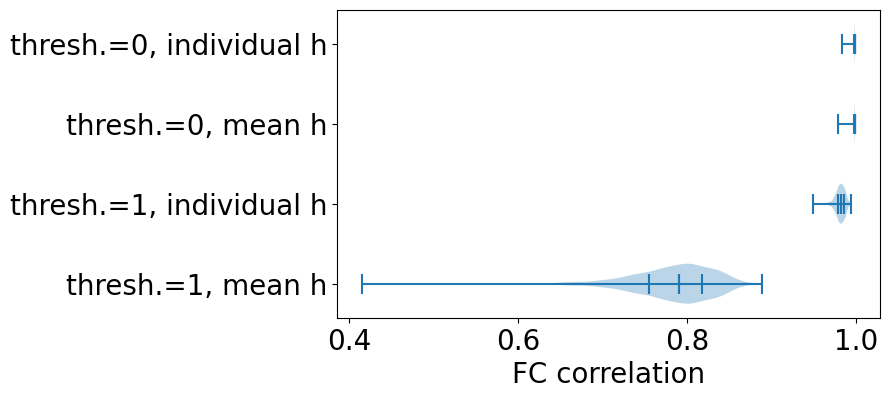

In [25]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(7, 4) )

corr_labels = ['thresh.=0, individual h', 'thresh.=0, mean h', 'thresh.=1, individual h', 'thresh.=1, mean h']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [ depytorch( fcc.flatten() ) for fcc in [fc_corr_individual_h_0, fc_corr_mean_h_0, fc_corr_individual_h_1, fc_corr_mean_h_1] ]
axs.violinplot(  list( reversed(all_corrs) ), showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal'  )
axs.set_yticks(label_x)
# plt.yticks(rotation=45)
axs.set_yticklabels(  list( reversed(corr_labels) )  )
axs.set_xlabel('FC correlation')

In [22]:
print(   'threshold=0,', stats.wilcoxon(  depytorch( fc_corr_individual_h_0.mean(dim=0) ), depytorch( fc_corr_mean_h_0.mean(dim=0) ), alternative='greater'  )   )

threshold=0, WilcoxonResult(statistic=np.float64(215670.0), pvalue=np.float64(4.141584170201563e-09))


In [23]:
print(   'threshold=1,', stats.wilcoxon(  depytorch( fc_corr_individual_h_1.mean(dim=0) ), depytorch( fc_corr_mean_h_1.mean(dim=0) ), alternative='greater'  )   )

threshold=1, WilcoxonResult(statistic=np.float64(350703.0), pvalue=np.float64(6.391993315865764e-139))


In [27]:
threshold_0_fc_corr_diff = fc_corr_individual_h_0.mean(dim=0) - fc_corr_mean_h_0.mean(dim=0)
print( f'threshold=0, min {threshold_0_fc_corr_diff.min():.3g}, median {threshold_0_fc_corr_diff.median():.3g}, max {threshold_0_fc_corr_diff.max():.3g}' )

threshold=0, min -0.000742, median 3.81e-05, max 0.00152


In [28]:
threshold_1_fc_corr_diff = fc_corr_individual_h_1.mean(dim=0) - fc_corr_mean_h_1.mean(dim=0)
print( f'threshold=1, min {threshold_1_fc_corr_diff.min():.3g}, median {threshold_1_fc_corr_diff.median():.3g}, max {threshold_1_fc_corr_diff.max():.3g}' )

threshold=1, min 0.0997, median 0.192, max 0.567


In [15]:
bad_subject = torch.nonzero(fc_corr_individual_h_0[0,:] < 0.9).item()
print( bad_subject )
all_but_bad = torch.arange( fc_corr_individual_h_0.size(dim=-1), dtype=int_type, device=device ) != bad_subject
print( all_but_bad.size(), all_but_bad.dtype )
fc_corr_individual_h_0 = fc_corr_individual_h_0[:,all_but_bad]
fc_corr_mean_h_0 = fc_corr_mean_h_0[:,all_but_bad]
fc_corr_individual_h_1 = fc_corr_individual_h_1[:,all_but_bad]
fc_corr_mean_h_1 = fc_corr_mean_h_1[:,all_but_bad]

RuntimeError: a Tensor with 0 elements cannot be converted to Scalar